This notebook will look for the following pattern:
- WT not associated with time.
    - P > 0.05 and abs log2FC < log2(1.5)
- MUT associated with time.
    - P < 0.05 and abs log2FC > 1

The bottom line is that no comparison is taken between WT and MUT at neither initial nor last time points. So, if initial conditions do not match it is OK and also, situations such that MUT reaches the flat WT are also OK.

In [1]:
import pandas, numpy, termcolor, seaborn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_DESeq2/strict/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/DESeq2_TPM_values.tsv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
dorothea_file = '/home/adrian/software/dorothea/mmusculus/mmusculus.dorothea.txt'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

# 1. read data

## 1.1. read expression

In [4]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
expression.head()

a3922_0h_1  a3922_0h_2  a3922_0h_3  a3922_48h_1  \
ENSMUSG00000000001   65.244411   65.953285   64.396929    75.289955   
ENSMUSG00000000003    0.000000    0.000000    0.000000     0.000000   
ENSMUSG00000000028    5.945436    5.464240    4.924612    20.245428   
ENSMUSG00000000037    0.220972    0.959207    0.258270     0.969948   
ENSMUSG00000000049    0.061451    0.061879    0.096945     0.000000   

                    a3922_48h_2  a3922_48h_3  a3922_72h_1  a3922_72h_2  \
ENSMUSG00000000001    71.147817    72.146832    67.786762    70.217188   
ENSMUSG00000000003     0.000000     0.000000     0.000000     0.000000   
ENSMUSG00000000028    19.780706    22.747363    19.239938    22.062649   
ENSMUSG00000000037     1.149452     2.212842     0.989879     2.354492   
ENSMUSG00000000049     0.071373     0.000000     0.059768     0.000000   

                    a3922_72h_3  a4774_0h_1  ...  a4775_72h_3  a4776_0h_1  \
ENSMUSG00000000001    70.219265   61.227221  ...    68.440778   64.806231   
ENSMUSG00000000003     0.000000    0.000000  ...     0.000000    0.000000   
ENSMUSG00000000028    20.547492    7.843197  ...    14.565935    4.712688   
ENSMUSG00000000037     1.813624    0.545637  ...     0.989086    0.451844   
ENSMUSG00000000049     0.000000    0.214027  ...     0.761343    0.000000   

                    a4776_0h_2  a4776_0h_3  a4776_48h_1  a4776_48h_2  \
ENSMUSG00000000001   65.619286   66.749396    64.425407    68.665136   
ENSMUSG00000000003    0.000000    0.000000     0.000000     0.000000   
ENSMUSG00000000028    3.690099    4.120889     7.220914     8.377850   
ENSMUSG00000000037    0.523639    0.679725     2.862086     0.865126   
ENSMUSG00000000049    0.125876    0.000000     0.000000     0.096454   

                    a4776_48h_3  a4776_72h_1  a4776_72h_2  a4776_72h_3  
ENSMUSG00000000001    68.419059    69.705546    70.717428    71.017699  
ENSMUSG00000000003     0.000000     0.000000     0.000000     0.000000  
ENSMUSG00000000028     9.611563     9.465468    10.235803     9.808747  
ENSMUSG00000000037     1.973570     1.612622     2.148935     5.445061  
ENSMUSG00000000049     0.130578     0.000000     0.000000     0.000000  

[5 rows x 35 columns]

## 1.2. read annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


gene_biotype  \
ens_gene                          
ENSMUSG00000064336      Mt_tRNA   
ENSMUSG00000064337      Mt_rRNA   
ENSMUSG00000064338      Mt_tRNA   
ENSMUSG00000064339      Mt_rRNA   
ENSMUSG00000064340      Mt_tRNA   

                                                          description ext_gene  
ens_gene                                                                        
ENSMUSG00000064336  mitochondrially encoded tRNA phenylalanine [So...    mt-Tf  
ENSMUSG00000064337  mitochondrially encoded 12S rRNA [Source:MGI S...  mt-Rnr1  
ENSMUSG00000064338  mitochondrially encoded tRNA valine [Source:MG...    mt-Tv  
ENSMUSG00000064339  mitochondrially encoded 16S rRNA [Source:MGI S...  mt-Rnr2  
ENSMUSG00000064340  mitochondrially encoded tRNA leucine 1 [Source...   mt-Tl1

# 2. transform expression to be more amenable to downstream analysis

In [6]:
df = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        df[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
df.head()

a3922_0h  a3922_48h  a3922_72h   a4774_0h  a4774_48h  \
ENSMUSG00000000001  65.244411  72.146832  70.217188  61.227221  65.197716   
ENSMUSG00000000003   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000000028   5.464240  20.245428  20.547492   7.843197   8.262456   
ENSMUSG00000000037   0.258270   1.149452   1.813624   0.567393   1.344796   
ENSMUSG00000000049   0.061879   0.000000   0.000000   0.214027   0.000000   

                    a4774_72h   a4775_0h  a4775_48h  a4775_72h   a4776_0h  \
ENSMUSG00000000001  64.804086  55.869249  65.371837  68.440778  65.619286   
ENSMUSG00000000003   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000000028  11.467644   8.258439  15.989181  16.179836   4.120889   
ENSMUSG00000000037   1.122762   0.472029   0.958435   1.713961   0.523639   
ENSMUSG00000000049   0.000000   0.149524   0.000000   0.441745   0.000000   

                    a4776_48h  a4776_72h  
ENSMUSG00000000001  68.419059  70.717428  
ENSMUSG00000000003   0.000000   0.000000  
ENSMUSG00000000028   8.377850   9.808747  
ENSMUSG00000000037   1.973570   2.148935  
ENSMUSG00000000049   0.096454   0.000000

In [7]:
for label in df.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        df.rename(columns = {label:new_label}, inplace=True)
df.head()

WT_0h     WT_48h     WT_72h   a4774_0h  a4774_48h  \
ENSMUSG00000000001  65.244411  72.146832  70.217188  61.227221  65.197716   
ENSMUSG00000000003   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000000028   5.464240  20.245428  20.547492   7.843197   8.262456   
ENSMUSG00000000037   0.258270   1.149452   1.813624   0.567393   1.344796   
ENSMUSG00000000049   0.061879   0.000000   0.000000   0.214027   0.000000   

                    a4774_72h   a4775_0h  a4775_48h  a4775_72h   a4776_0h  \
ENSMUSG00000000001  64.804086  55.869249  65.371837  68.440778  65.619286   
ENSMUSG00000000003   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000000028  11.467644   8.258439  15.989181  16.179836   4.120889   
ENSMUSG00000000037   1.122762   0.472029   0.958435   1.713961   0.523639   
ENSMUSG00000000049   0.000000   0.149524   0.000000   0.441745   0.000000   

                    a4776_48h  a4776_72h  
ENSMUSG00000000001  68.419059  70.717428  
ENSMUSG00000000003   0.000000   0.000000  
ENSMUSG00000000028   8.377850   9.808747  
ENSMUSG00000000037   1.973570   2.148935  
ENSMUSG00000000049   0.096454   0.000000

In [8]:
simple_expression = df.iloc[:, :3]
simple_expression.head()

WT_0h     WT_48h     WT_72h
ENSMUSG00000000001  65.244411  72.146832  70.217188
ENSMUSG00000000003   0.000000   0.000000   0.000000
ENSMUSG00000000028   5.464240  20.245428  20.547492
ENSMUSG00000000037   0.258270   1.149452   1.813624
ENSMUSG00000000049   0.061879   0.000000   0.000000

In [9]:
simple_expression = df.iloc[:, :3]

for time in times:
    condition_labels = [label for label in df.columns if time in label and 'WT' not in label]
    simple_expression['MUT_' + time] = df.loc[:, condition_labels].median(axis=1)

simple_expression.head()

WT_0h     WT_48h     WT_72h     MUT_0h    MUT_48h  \
ENSMUSG00000000001  65.244411  72.146832  70.217188  61.227221  65.371837   
ENSMUSG00000000003   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000000028   5.464240  20.245428  20.547492   7.843197   8.377850   
ENSMUSG00000000037   0.258270   1.149452   1.813624   0.523639   1.344796   
ENSMUSG00000000049   0.061879   0.000000   0.000000   0.149524   0.000000   

                      MUT_72h  
ENSMUSG00000000001  68.440778  
ENSMUSG00000000003   0.000000  
ENSMUSG00000000028  11.467644  
ENSMUSG00000000037   1.713961  
ENSMUSG00000000049   0.000000

# 3. search for pattern

## 3.1. retrieve genes that change with time in MUT phenotype

In [10]:
DEGs = []
for mouse in mice[1:]:
    path = DEG_folder + 'strict_MUTt72_over_MUTt0_' + mouse + '.tsv'
    df = pandas.read_csv(path, sep='\t', index_col=0)
    print(df.shape)
    DEGs.append(df.index.to_list())
    
    # checking for Snai2 ENSMUSG00000022676
    if 'ENSMUSG00000022676' in df.index:
        print('Snai2 found')
    if 'ENSMUSG00000016128' in df.index:
        print('Stard13 found')
    
list_one = list(set(DEGs[0]) & set(DEGs[1]) & set(DEGs[2]))
print(len(list_one))

(468, 6)
Snai2 found
(1049, 6)
Snai2 found
(1056, 6)
Snai2 found
218


In [11]:
# filter out genes that do not cross the abs log2FC > 1 and the max. expr. > 2
list_one_a = []
for ensembl in list_one:
    working_expression = simple_expression.loc[ensembl, :]
    start = numpy.round(simple_expression.loc[ensembl, 'MUT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'MUT_72h']) + 1
    abs_log2FC = numpy.abs(numpy.log2(end/start))    
    max_expr = numpy.max([start, end])
    
    if abs_log2FC > 1 and max_expr > 2+1:
        list_one_a.append(ensembl)
        
print(len(list_one_a))

142


## 3.2. check that genes are WT flat

In [12]:
path = DEG_folder + 'strict_WTt72_over_WTt0' + '.tsv'
df = pandas.read_csv(path, sep='\t', index_col=0)
print(df.shape)
DEGs = df.index.to_list()
list_four = list(set(DEGs))
print(len(list_four))

(1383, 6)
1383


In [13]:
if 'ENSMUSG00000022676' in list_four:
    print('Snai2 found') 

In [14]:
# a flat gene is a gene that:
# if has low expression (TPM < 2)
# elif abs log2FC < log(1.5) and not in significant group

list_four_a = []
for ensembl in simple_expression.index:
    start = numpy.round(simple_expression.loc[ensembl, 'WT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'WT_72h']) + 1
    max_expr = numpy.max([start, end])
    abs_log2FC = numpy.abs(numpy.log2(end/start))
    
    if ensembl == 'ENSMUSG00000022676':
        print('Snai2 abs log2FC for WT is {:.5} and the threshold is {:.5}'.format(abs_log2FC, numpy.log2(1.5)))
    
    if max_expr < 2+1:
        list_four_a.append(ensembl)
    if abs_log2FC < numpy.log2(1.5) and ensembl not in list_four:
        list_four_a.append(ensembl)
        
list_four_b = list(set(list_four_a))
print(len(simple_expression.index), len(list_four_a), len(list_four_b))

Snai2 abs log2FC for WT is 0.75207 and the threshold is 0.58496
35938 56784 33227


## 3.3. define gene set such that MUT changes and WT does not

In [15]:
list_five = []
for ensembl in list_one_a:
    if ensembl in list_four_b:
        list_five.append(ensembl)
print(len(list_five))

31


# 4. plot and print identified genes

## 4.1. print selected set of genes

In [16]:
for ensembl in list_five:
    print(ensembl)

ENSMUSG00000001751
ENSMUSG00000016496
ENSMUSG00000023009
ENSMUSG00000029861
ENSMUSG00000046727
ENSMUSG00000022243
ENSMUSG00000025511
ENSMUSG00000026857
ENSMUSG00000068220
ENSMUSG00000028194
ENSMUSG00000107874
ENSMUSG00000072941
ENSMUSG00000036698
ENSMUSG00000028713
ENSMUSG00000074892
ENSMUSG00000037049
ENSMUSG00000030084
ENSMUSG00000015766
ENSMUSG00000030796
ENSMUSG00000014444
ENSMUSG00000020190
ENSMUSG00000003617
ENSMUSG00000059013
ENSMUSG00000006235
ENSMUSG00000035273
ENSMUSG00000036853
ENSMUSG00000009687
ENSMUSG00000029510
ENSMUSG00000047793
ENSMUSG00000032564
ENSMUSG00000021696


This gives a small (3/22) but significant (P < 8e-3) enrichment on the term [HS-GAG degradation](https://reactome.org/content/detail/R-HSA-2024096), lysosomal degradation of glycosaminoglycans.  
The three genes are Naglu, Gpc2 and Hpse.

In [17]:
index = 0
for ensembl in list_five:
    index = index + 1
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0]
    if simple_expression.loc[ensembl, 'MUT_72h'] > simple_expression.loc[ensembl, 'MUT_0h']:
        trend = 'up'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'red'))
    else:
        trend = 'down'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'blue'))

1	ENSMUSG00000001751	Naglu	down	alpha-N-acetylglucosaminidase (Sanfilippo disease IIIB)
2	ENSMUSG00000016496	Cd274	up	CD274 antigen
3	ENSMUSG00000023009	Nckap5l	down	NCK-associated protein 5-like
4	ENSMUSG00000029861	Fam131b	up	family with sequence similarity 131, member B
5	ENSMUSG00000046727	Cystm1	down	cysteine-rich transmembrane module containing 1
6	ENSMUSG00000022243	Slc45a2	down	solute carrier family 45, member 2
7	ENSMUSG00000025511	Tspan4	down	tetraspanin 4
8	ENSMUSG00000026857	Ntmt1	down	N-terminal Xaa-Pro-Lys N-methyltransferase 1
9	ENSMUSG00000068220	Lgals1	down	lectin, galactose binding, soluble 1
10	ENSMUSG00000028194	Ddah1	down	dimethylarginine dimethylaminohydrolase 1
11	ENSMUSG00000107874	Prpmp5	down	proline-rich protein MP5
12	ENSMUSG00000072941	Sod3	up	superoxide dismutase 3, extracellular
13	ENSMUSG00000036698	Ago2	down	argonaute RISC catalytic subunit 2
14	ENSMUSG00000028713	Cyp4b1	up	cytochrome P450, family 4, subfamily b, polypeptide 1
15	ENSMUSG00000074892	B3gal

## 4.2. generate trajectory plots

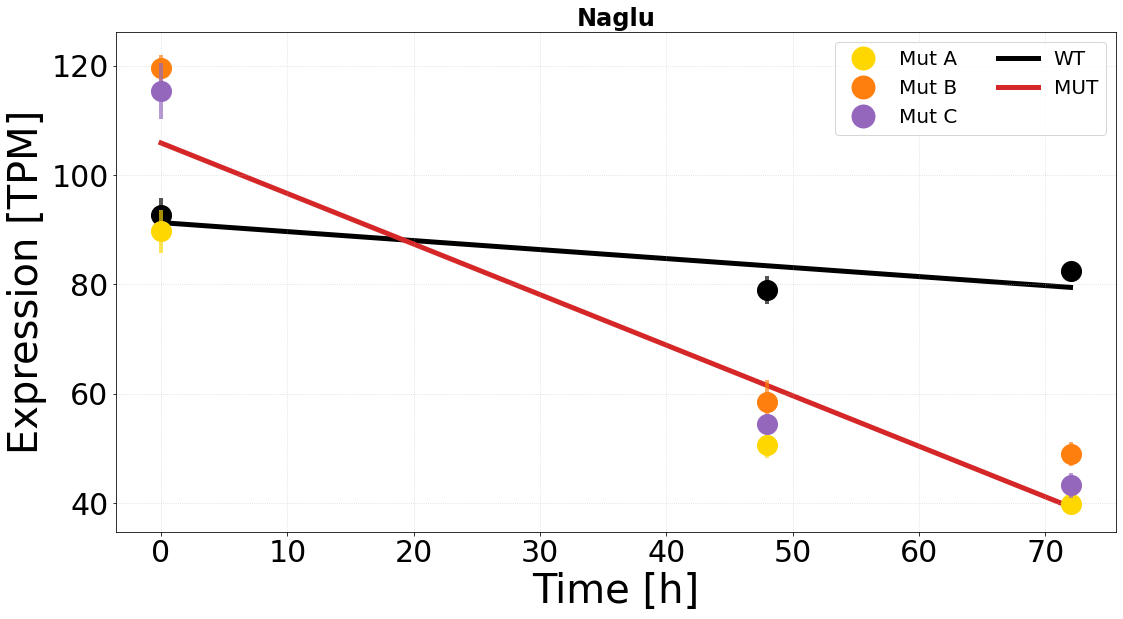

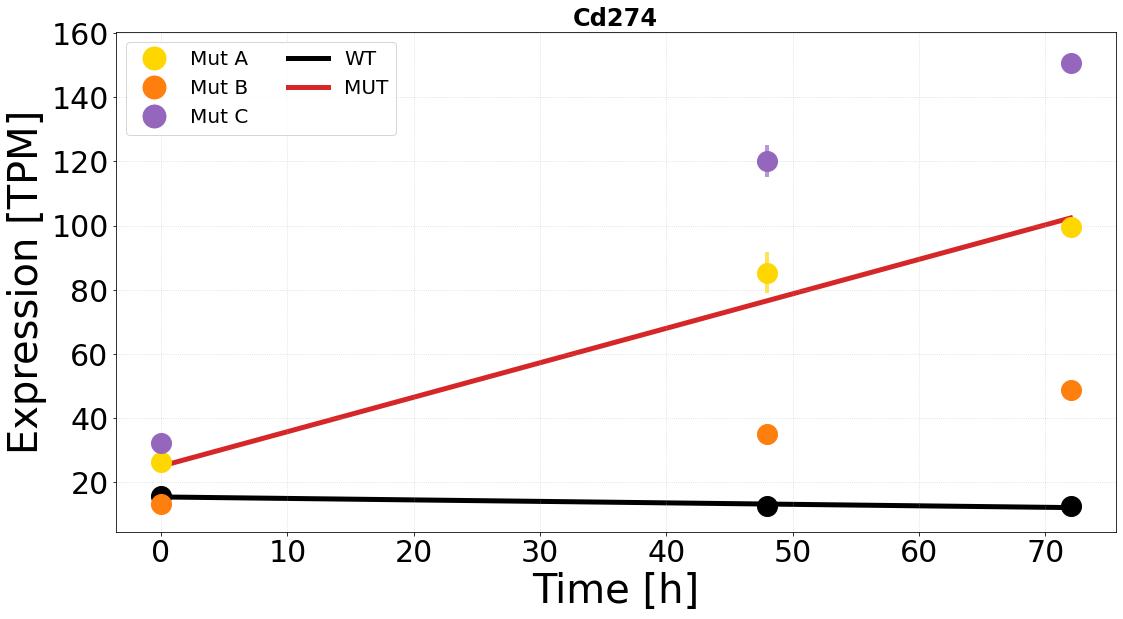

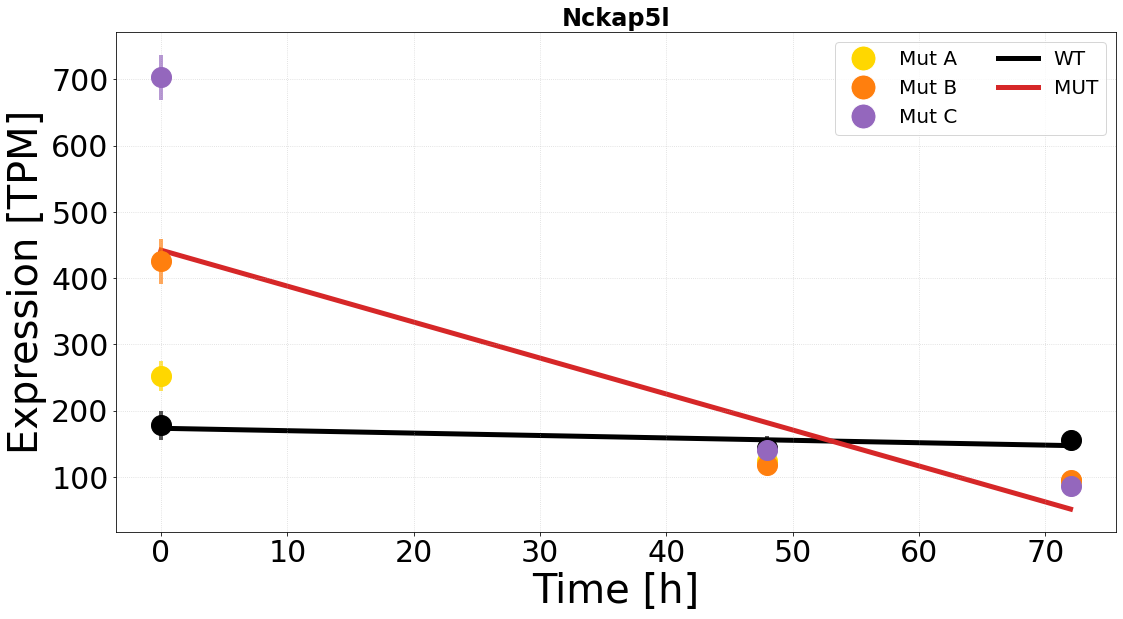

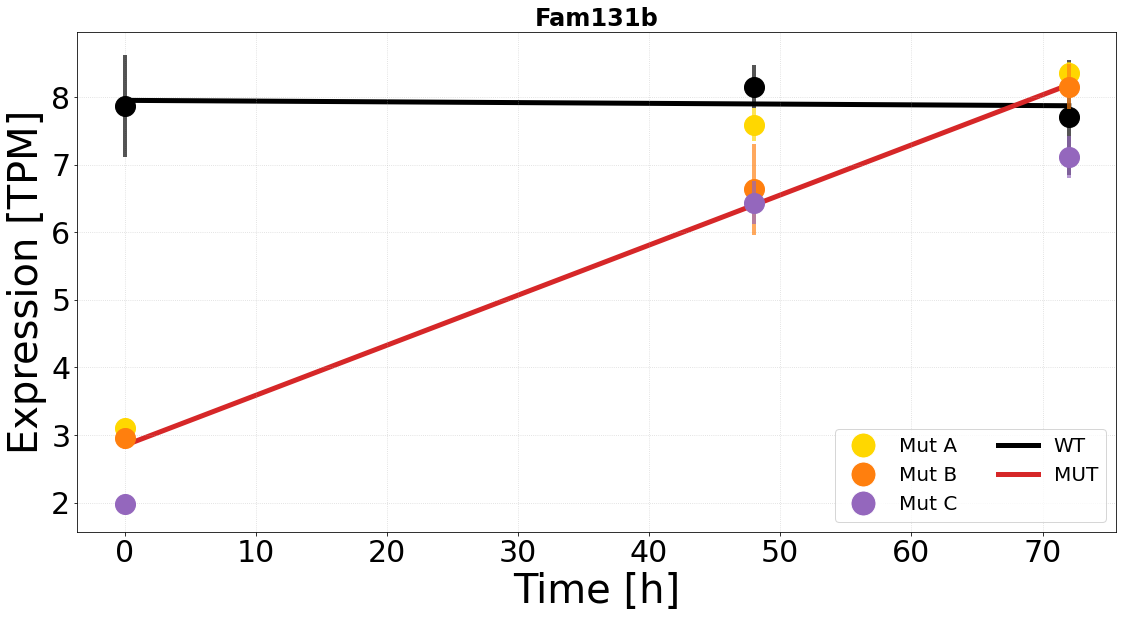

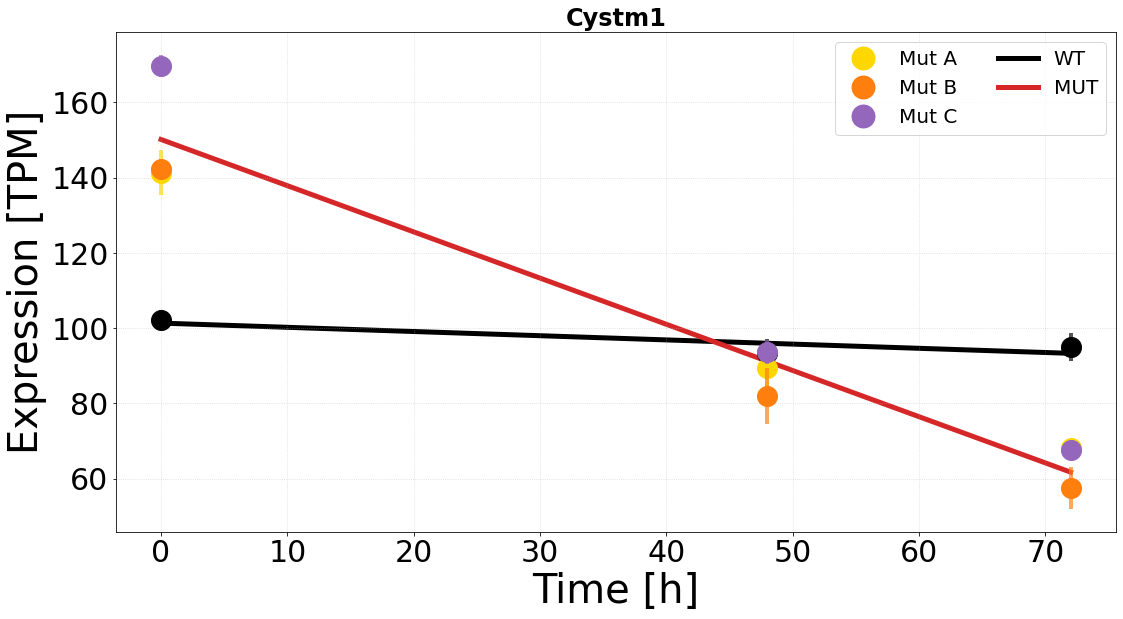

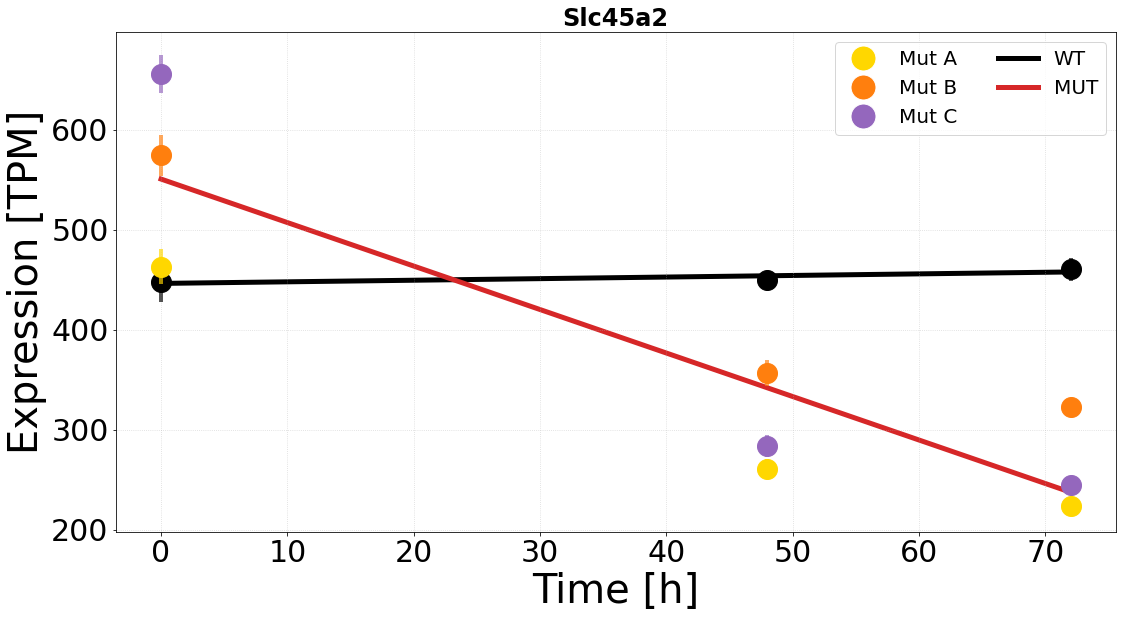

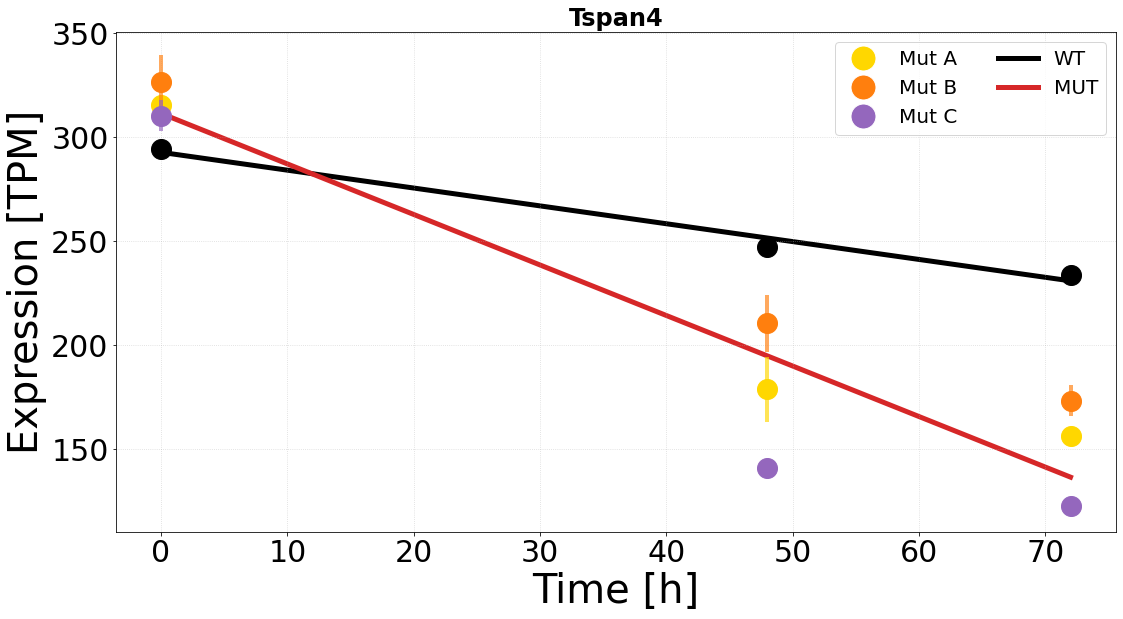

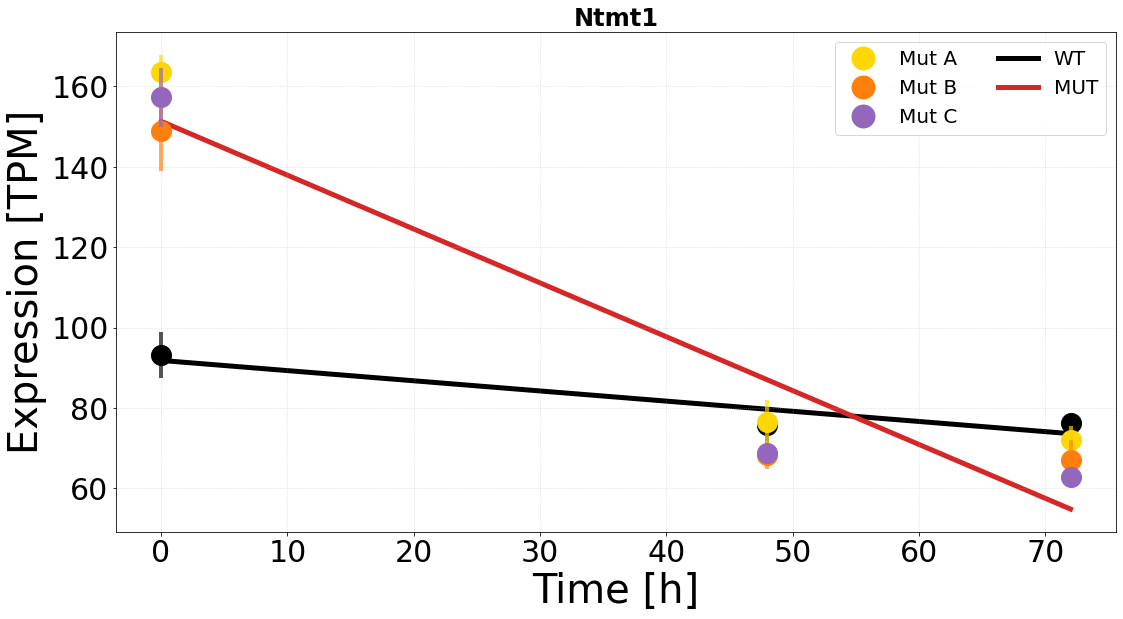

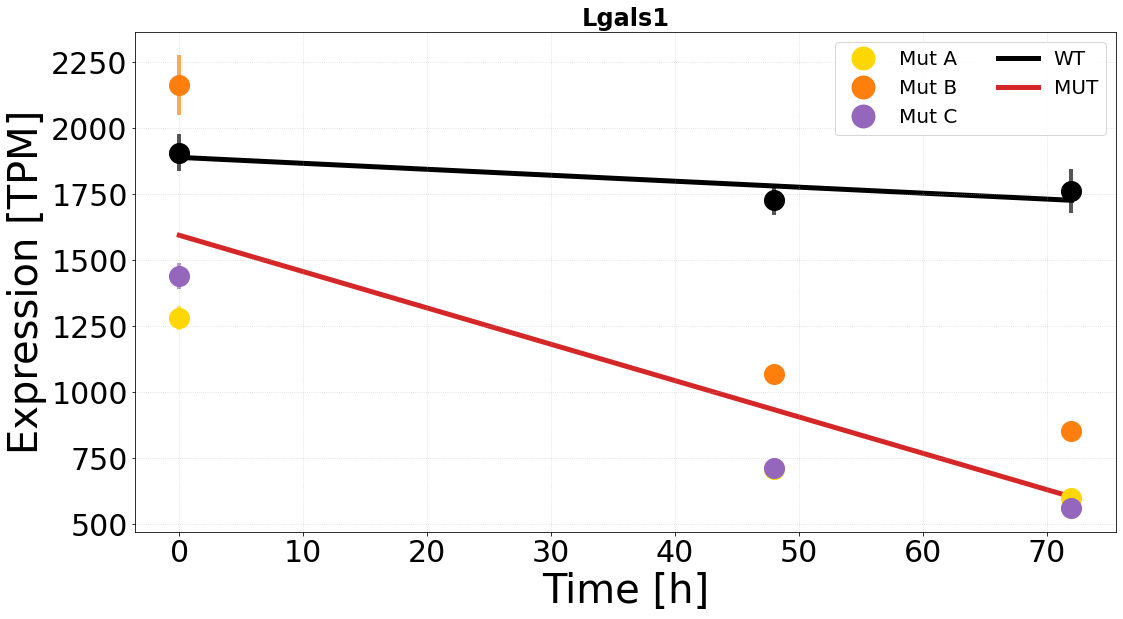

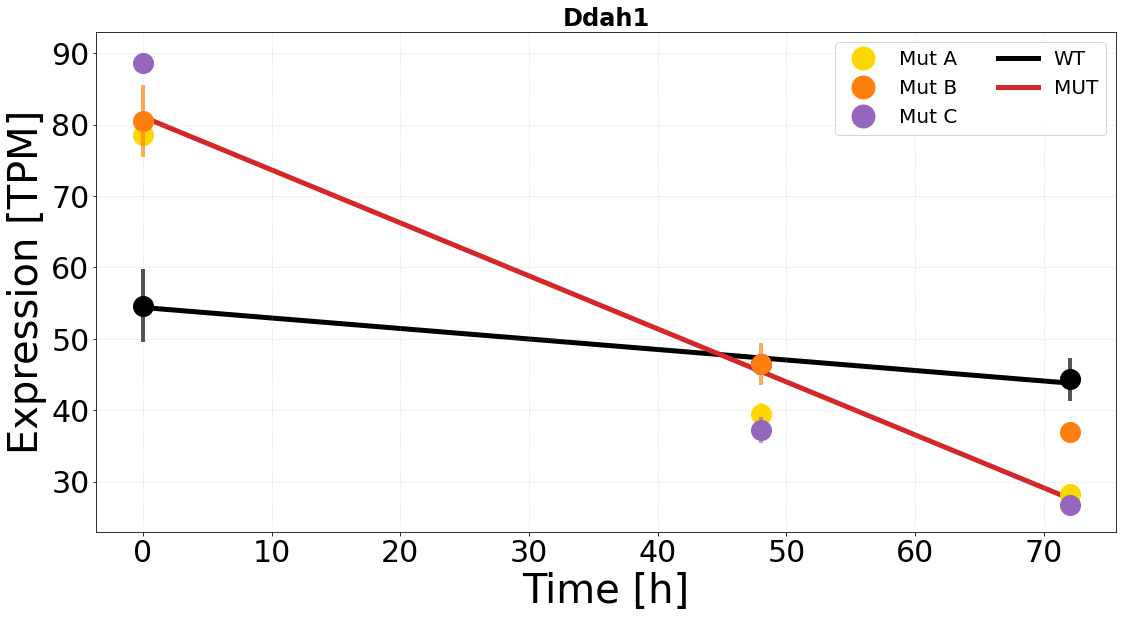

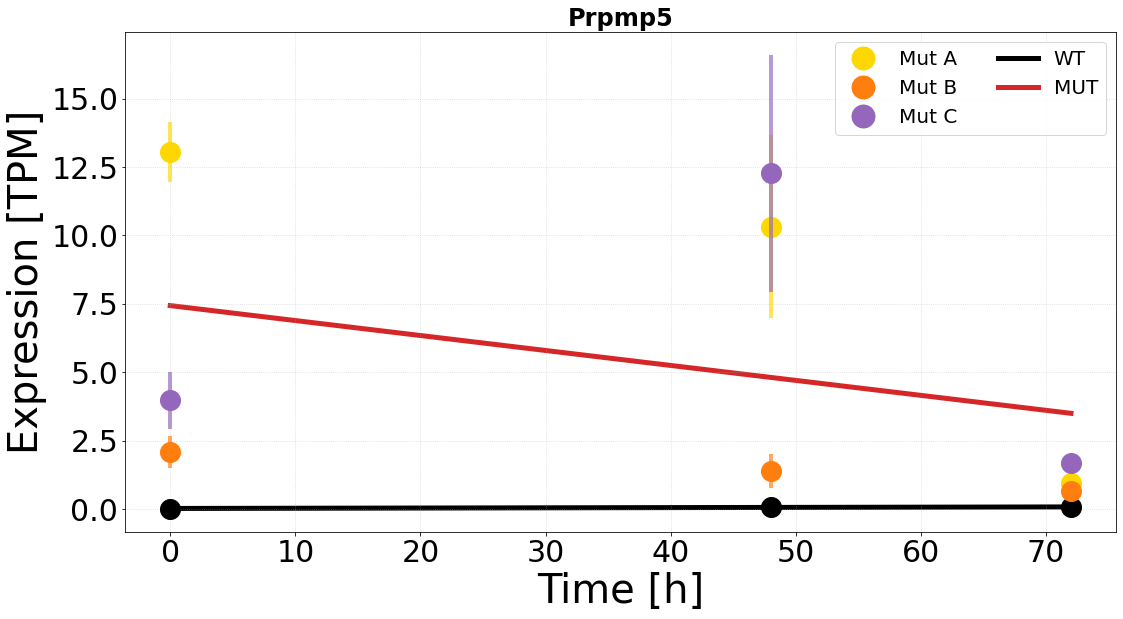

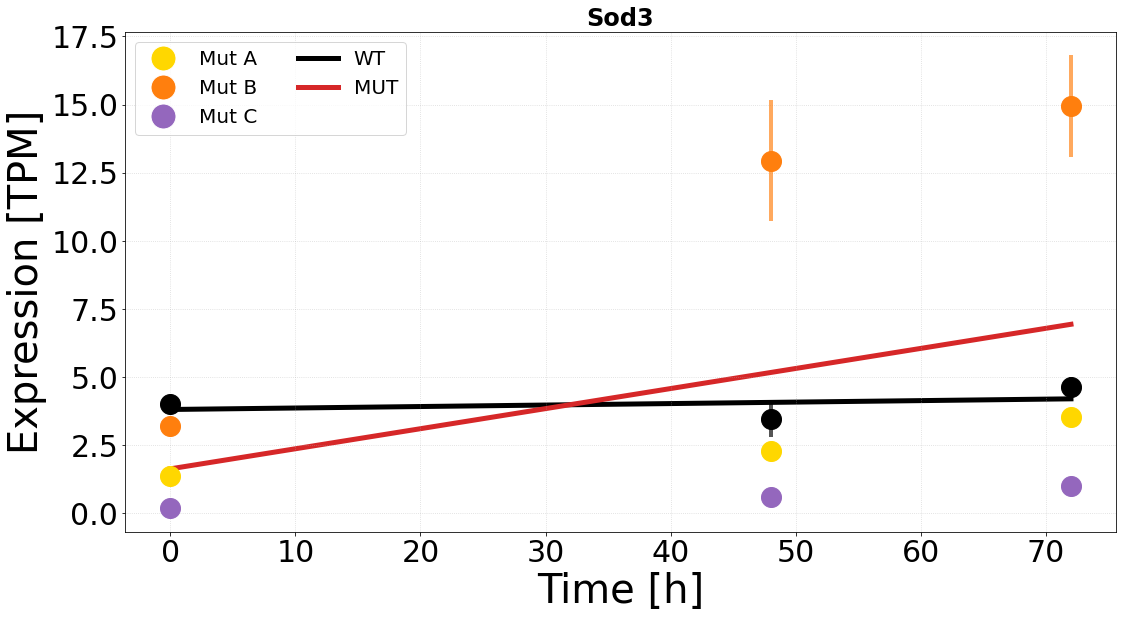

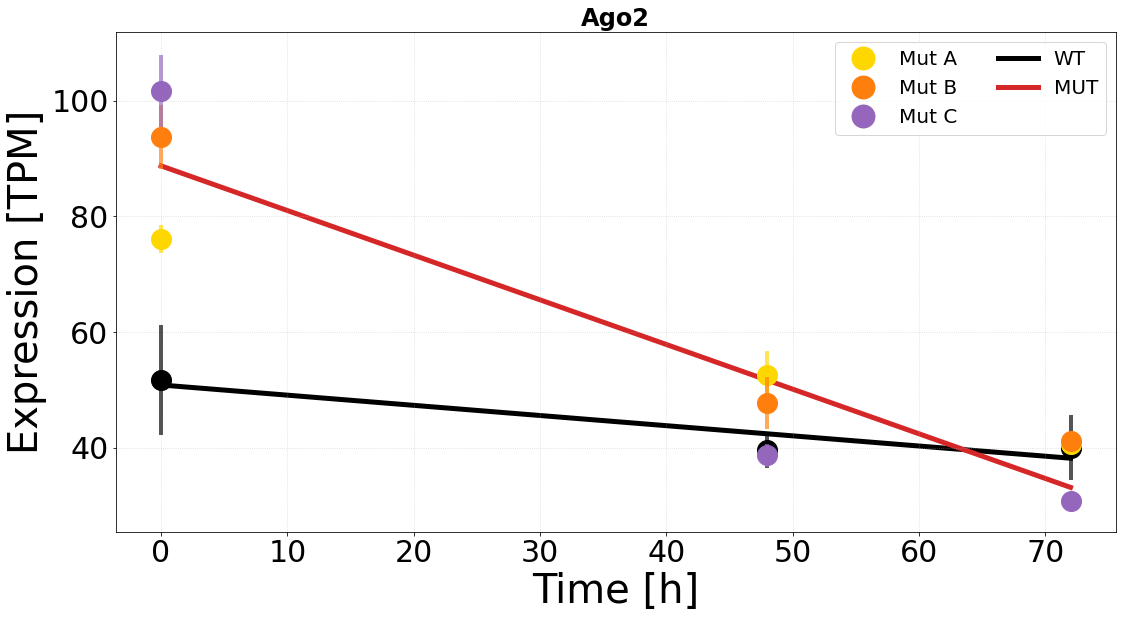

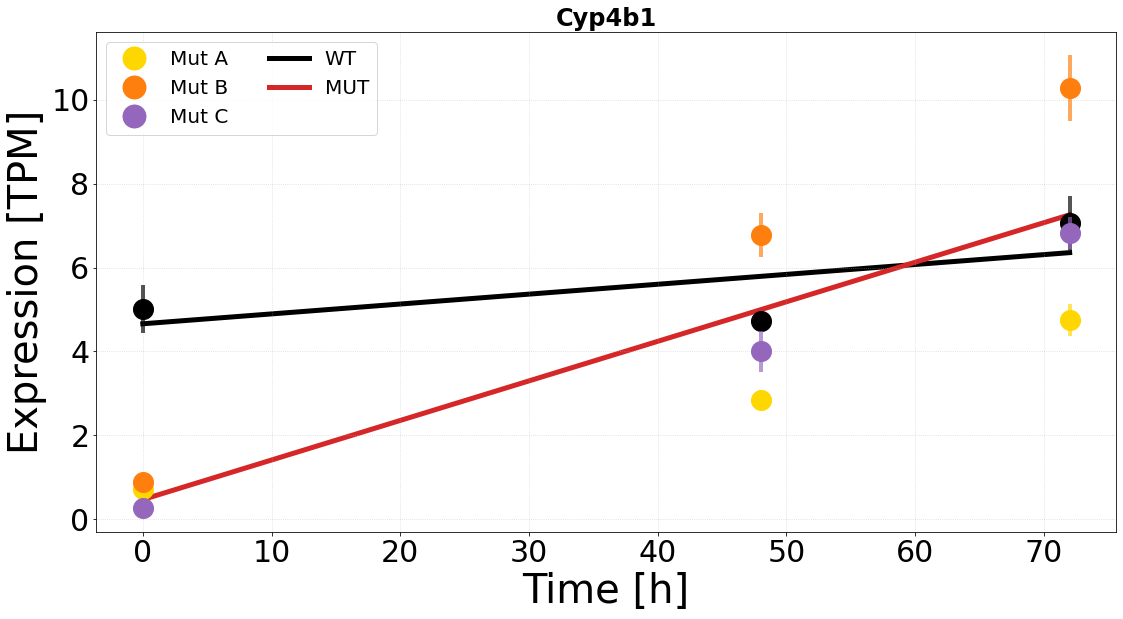

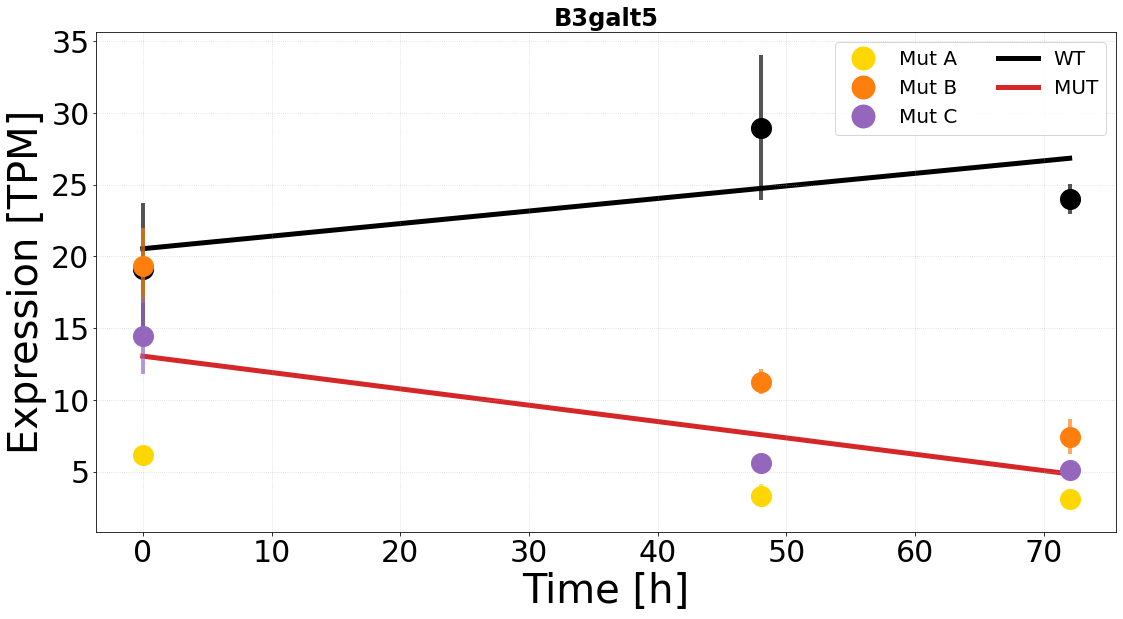

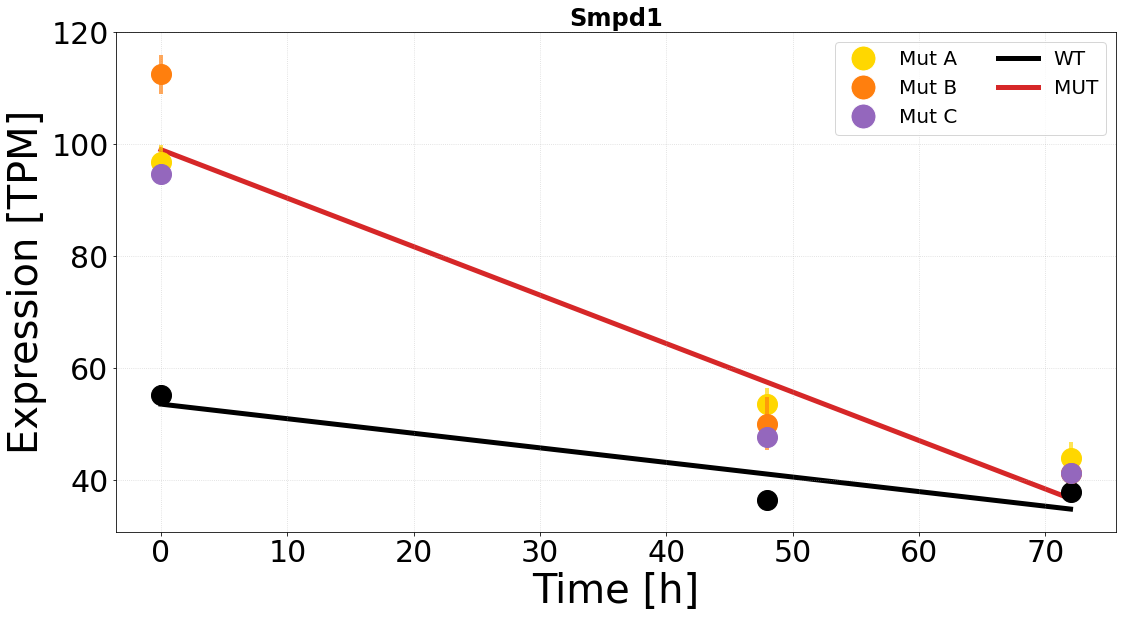

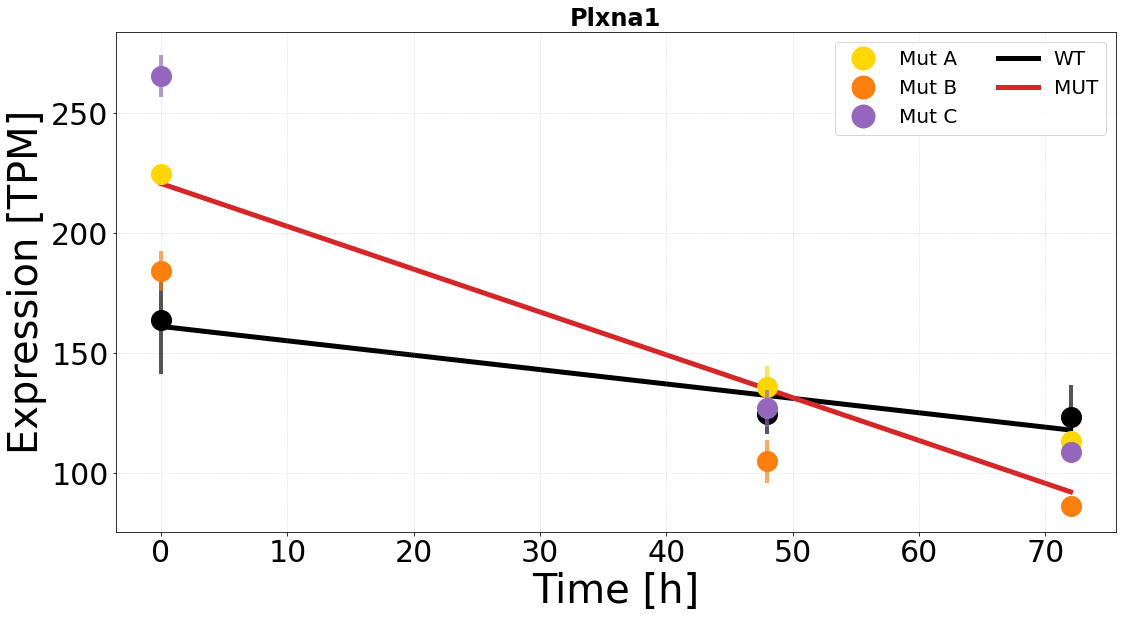

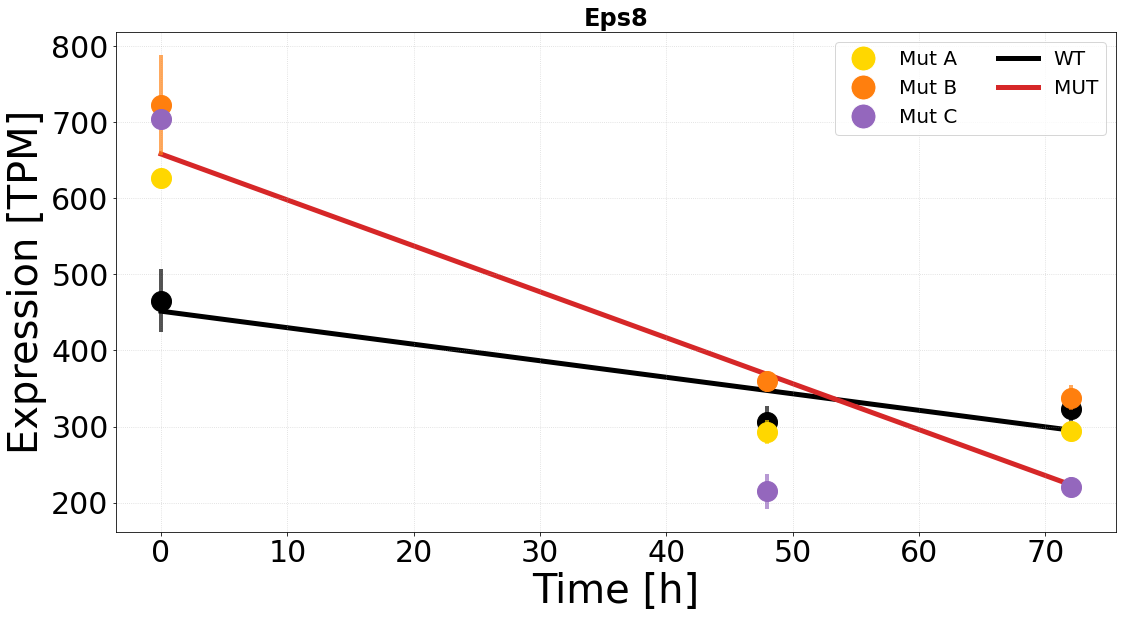

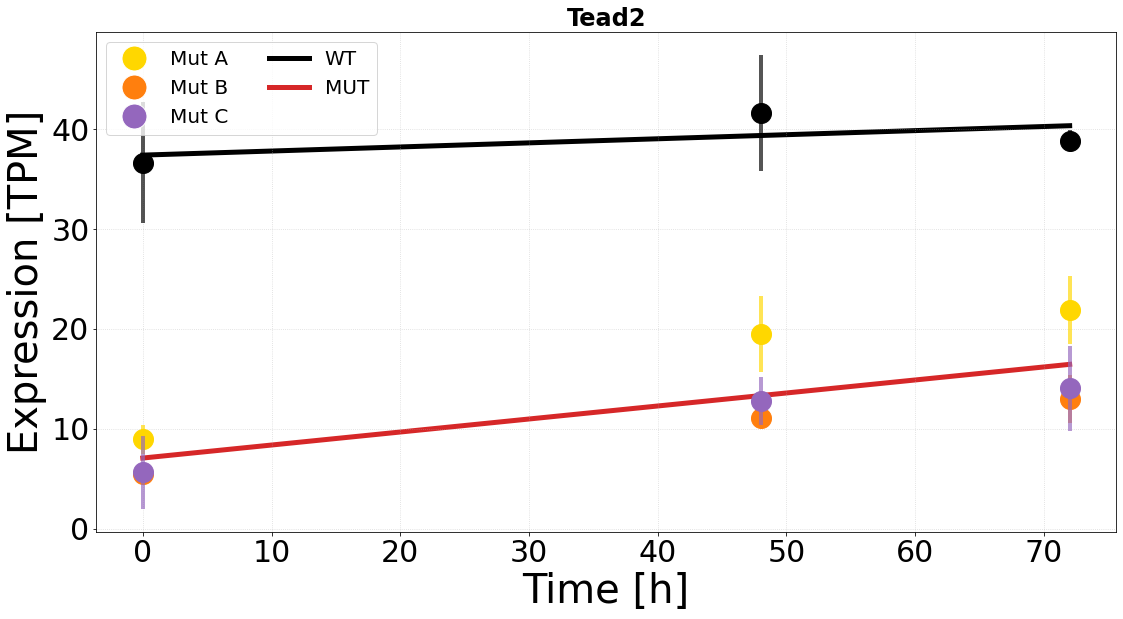

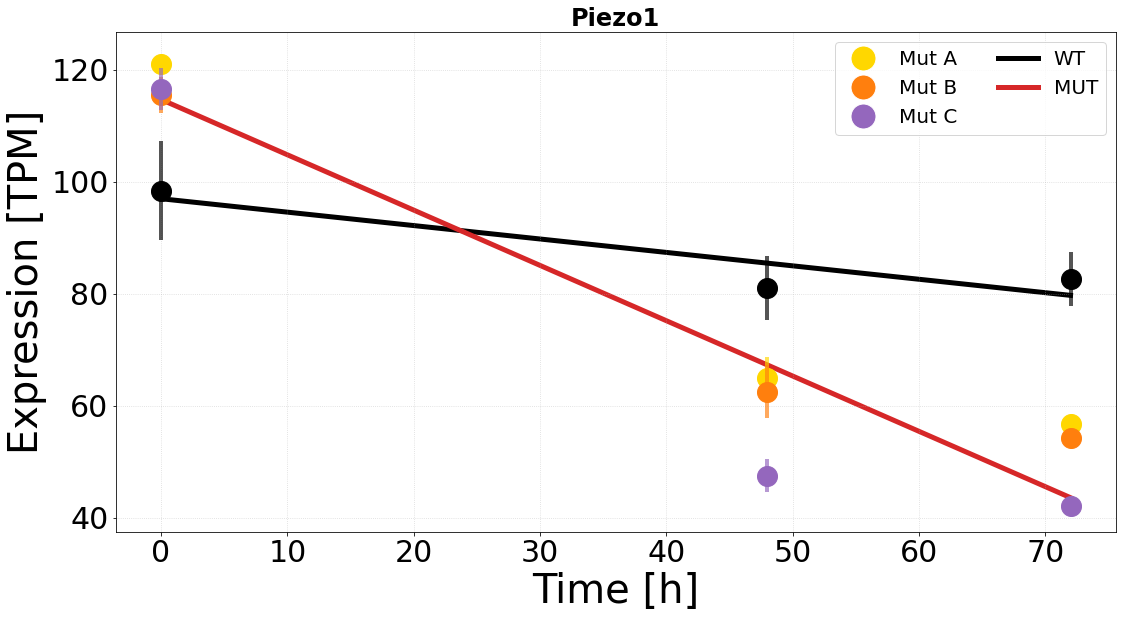

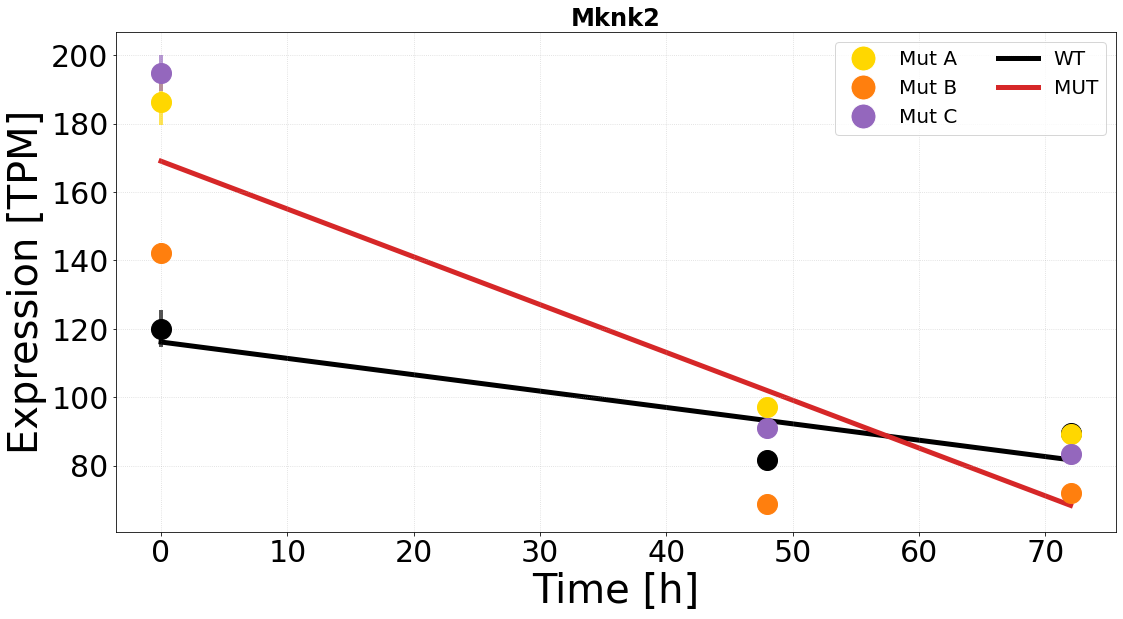

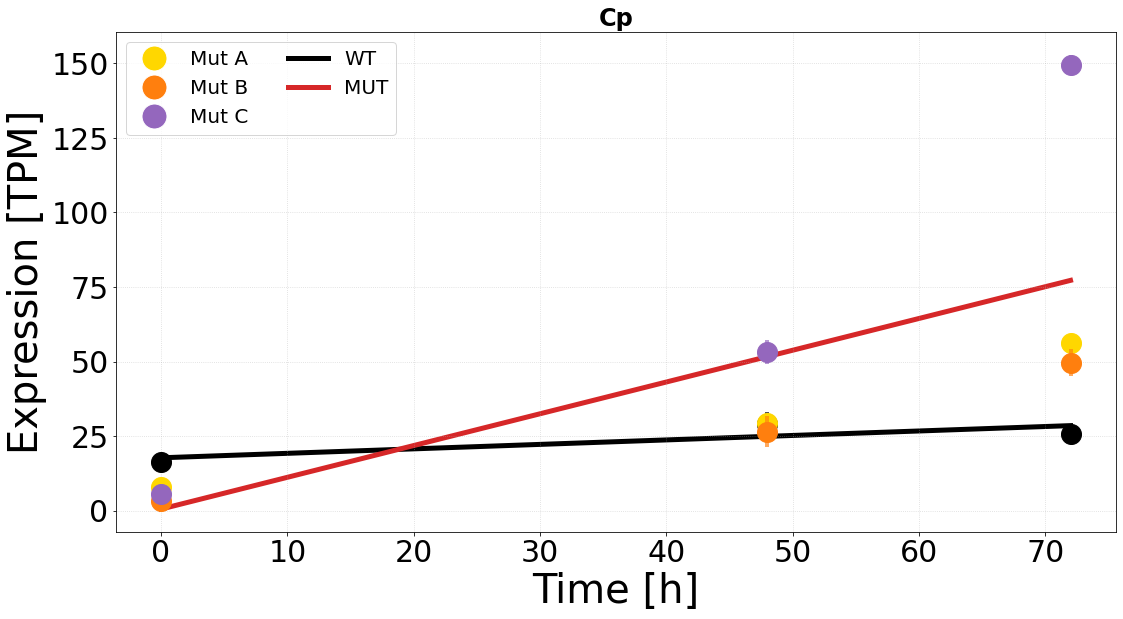

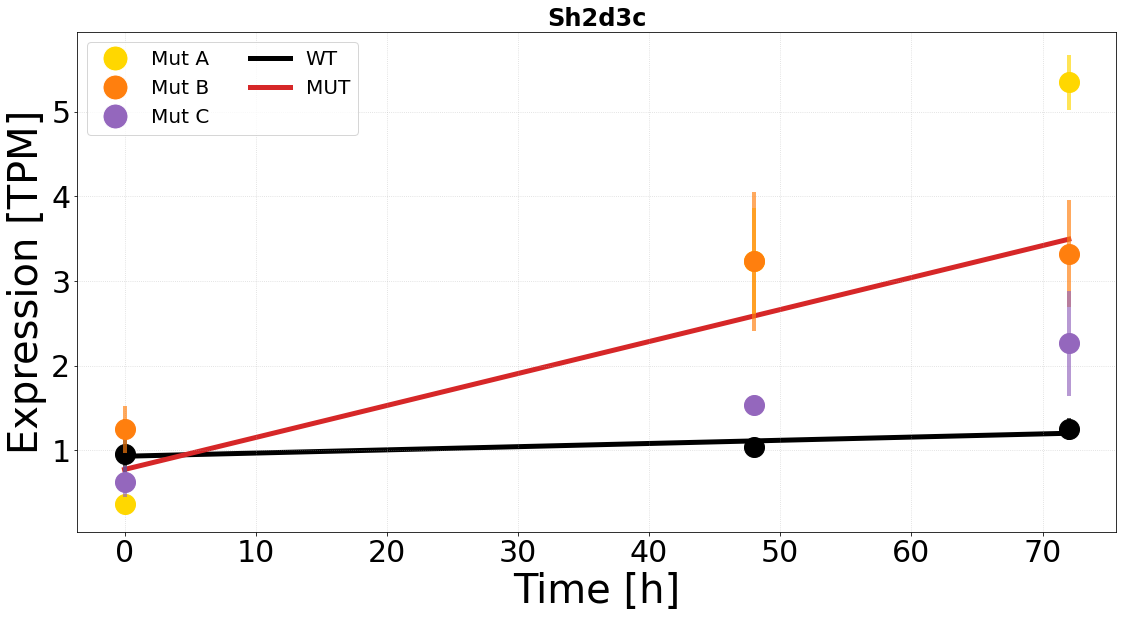

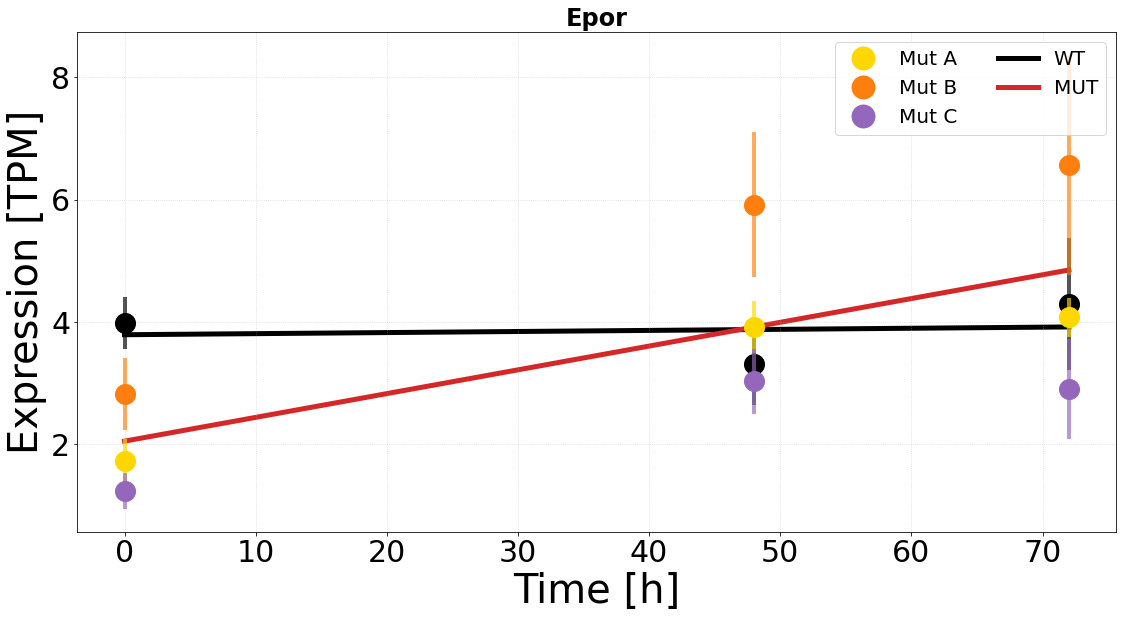

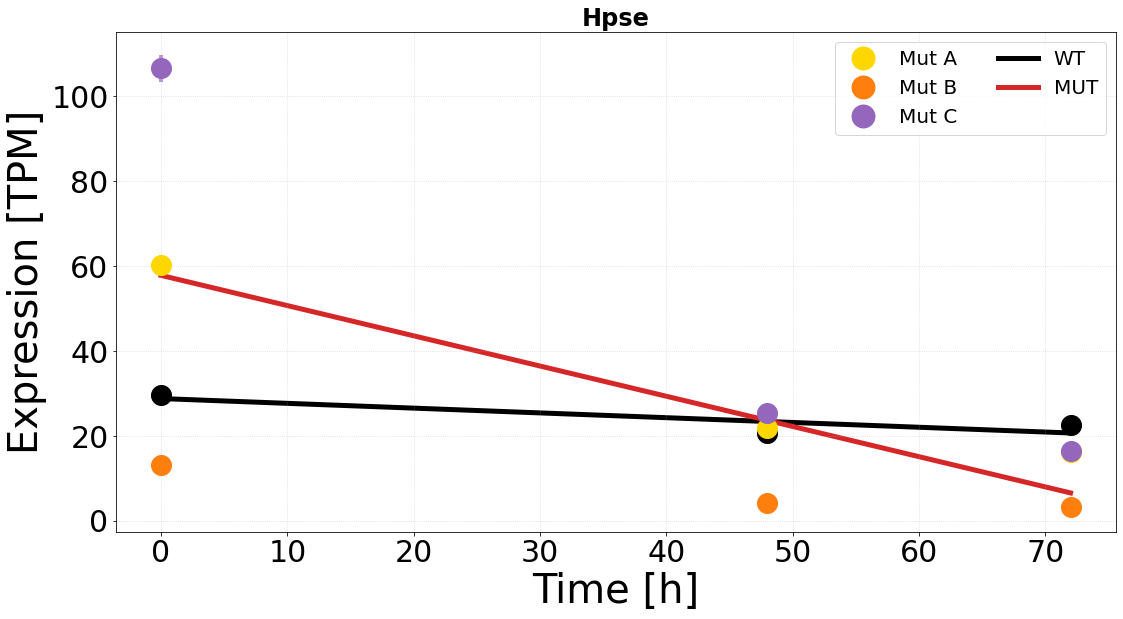

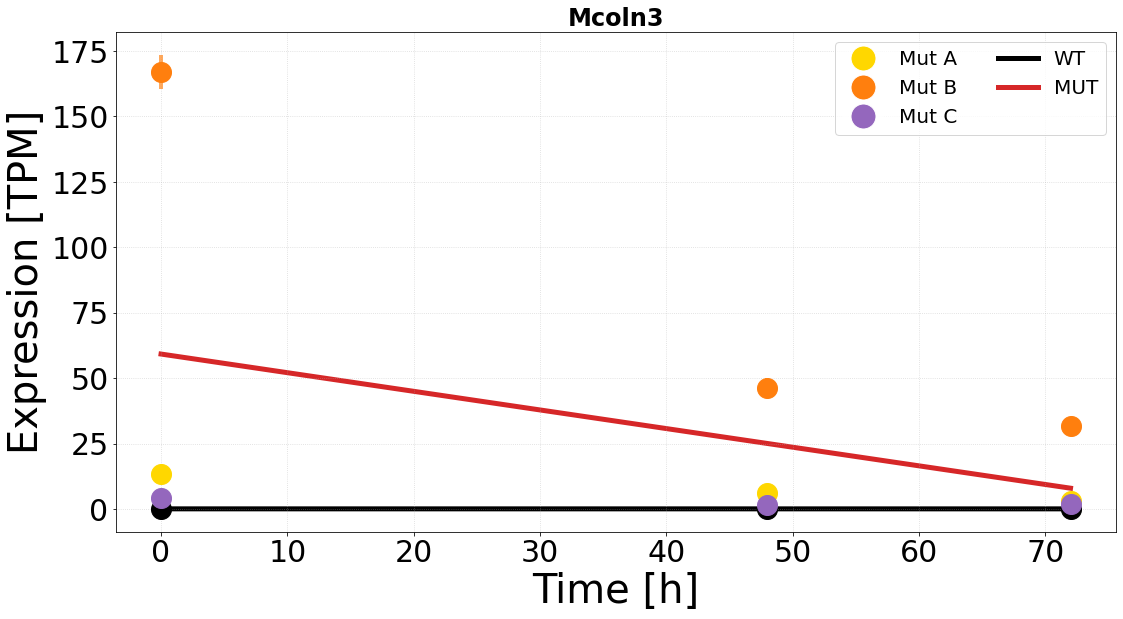

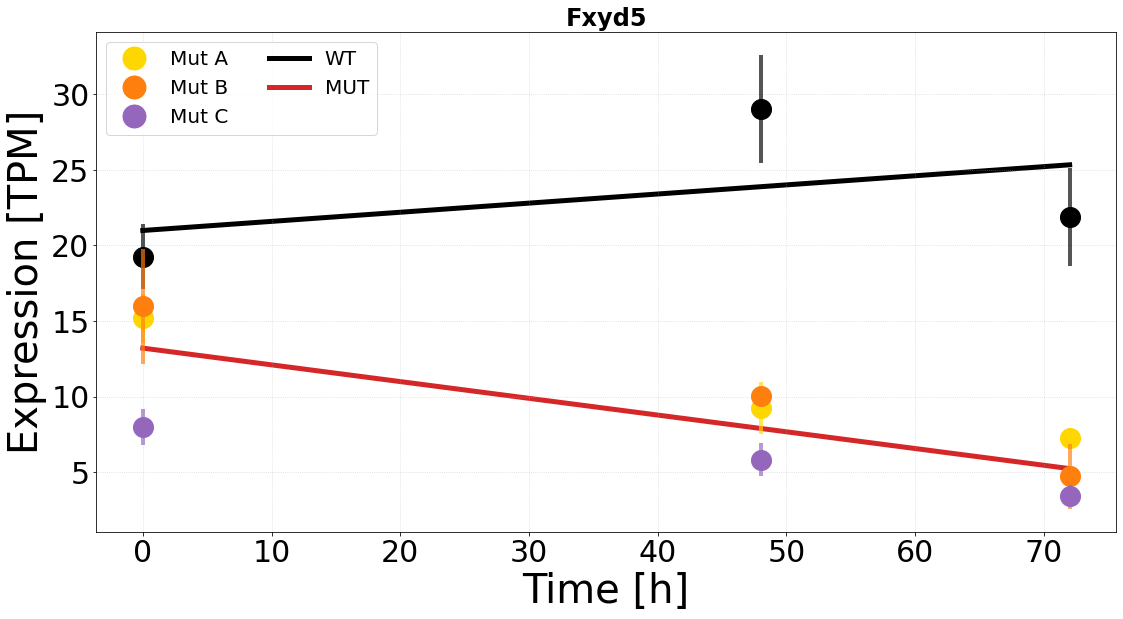

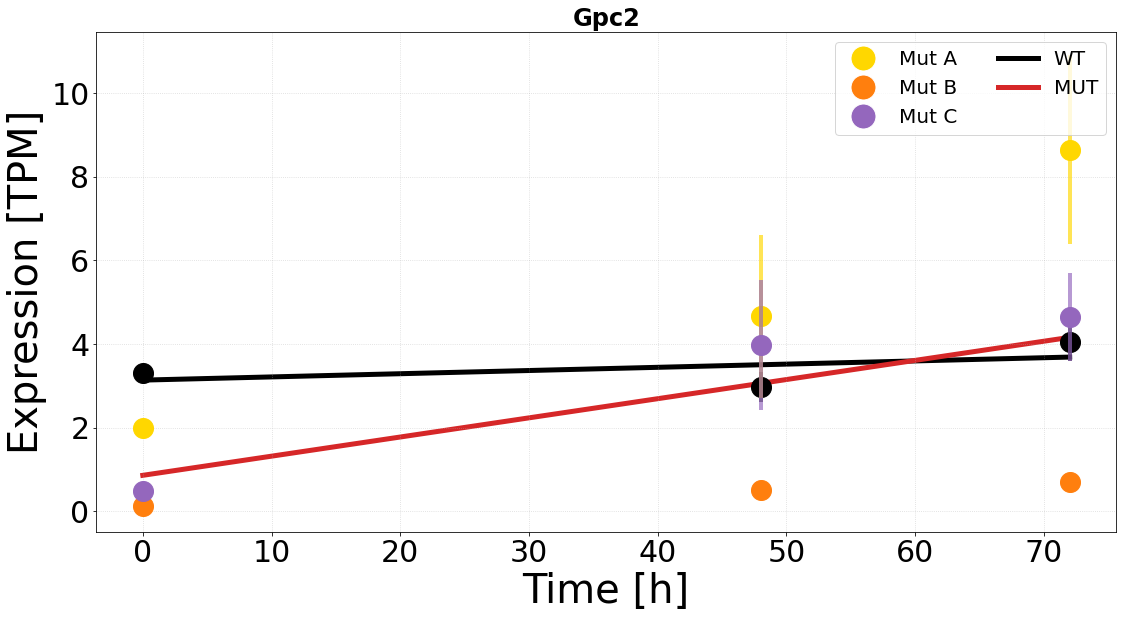

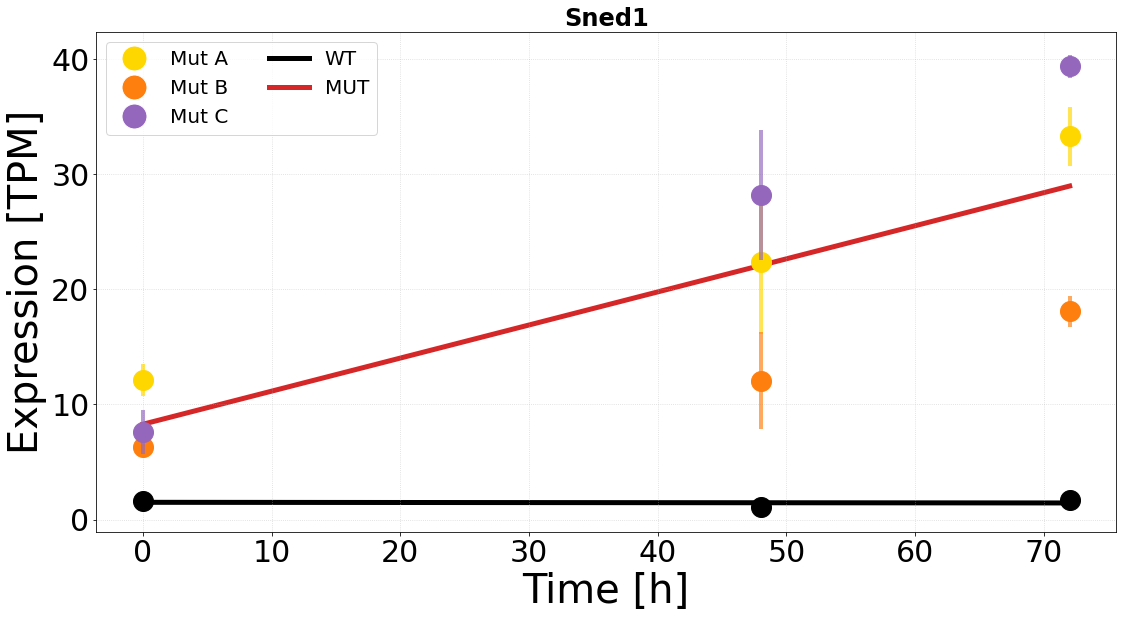

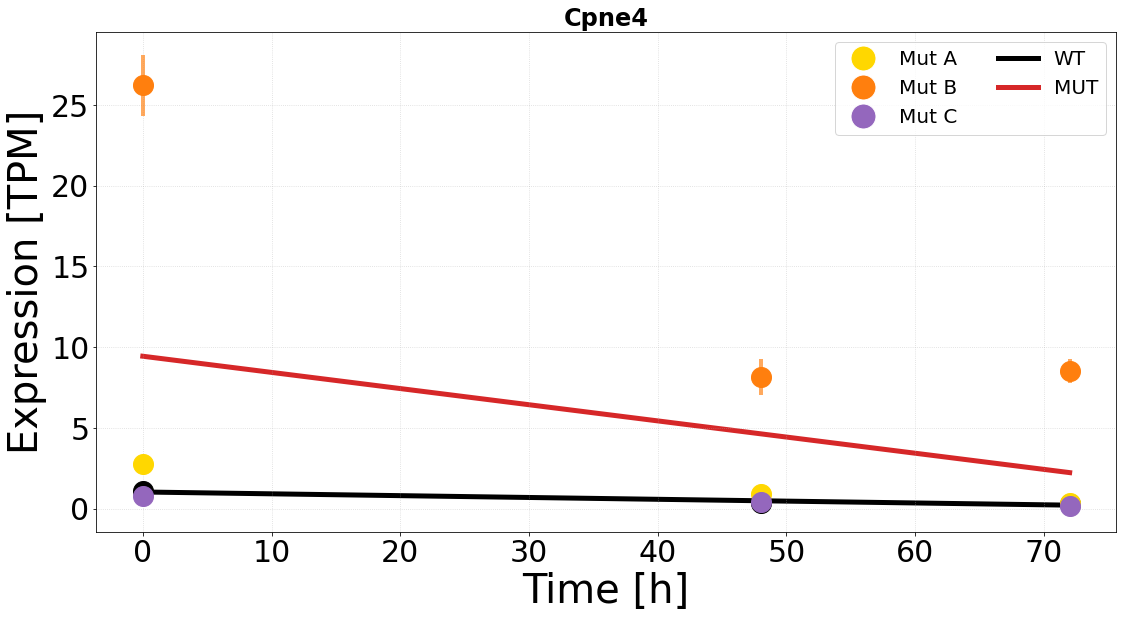

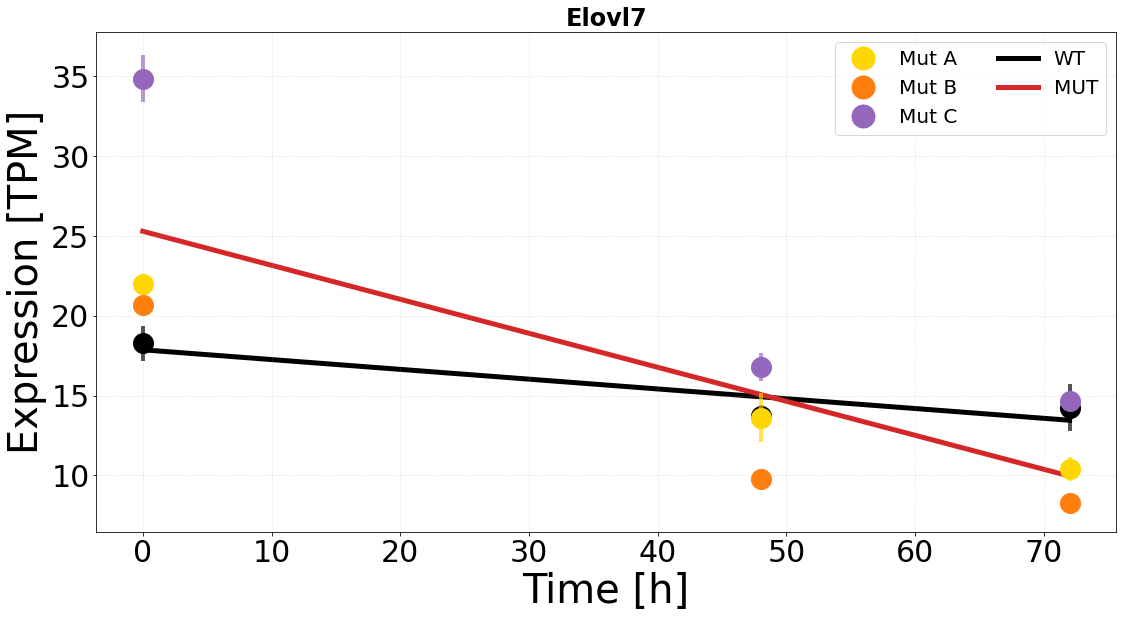

In [18]:
expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

for ensembl in list_five:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name, fontweight='bold')
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## 4.3. generate heatmap on z-score

In [19]:
df = pandas.DataFrame(fitted_change_dict)
tdf = df.transpose()
tdf.columns = simple_expression.columns
tdf.head()

WT_0h      WT_48h      WT_72h      MUT_0h     MUT_48h  \
Naglu     91.308325   83.408040   79.457897  105.879427   61.493980   
Cd274     15.482219   13.271012   12.165409   25.067039   76.603903   
Nckap5l  173.507691  156.087185  147.376931  442.242530  181.824959   
Fam131b    7.949244    7.896085    7.869505    2.845096    6.401196   
Cystm1   101.333716   95.978582   93.301015  150.127054   91.204085   

            MUT_72h  
Naglu     39.301257  
Cd274    102.372336  
Nckap5l   51.616173  
Fam131b    8.179247  
Cystm1    61.742600

In [20]:
rounded_df = numpy.round(tdf, 0) + 1
rounded_df.head()

WT_0h  WT_48h  WT_72h  MUT_0h  MUT_48h  MUT_72h
Naglu     92.0    84.0    80.0   107.0     62.0     40.0
Cd274     16.0    14.0    13.0    26.0     78.0    103.0
Nckap5l  175.0   157.0   148.0   443.0    183.0     53.0
Fam131b    9.0     9.0     9.0     4.0      7.0      9.0
Cystm1   102.0    97.0    94.0   151.0     92.0     63.0

In [21]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in rounded_df.index:
    average_expression = numpy.mean(numpy.log10(rounded_df.loc[gene_name, :]))
    fc_wt = (rounded_df.loc[gene_name, 'WT_72h']) / (rounded_df.loc[gene_name, 'WT_0h'])
    fc_mut = (rounded_df.loc[gene_name, 'MUT_72h']) / (rounded_df.loc[gene_name, 'MUT_0h'])
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    
    volcanox.append(delta); volcanoy.append(average_expression)

In [22]:
zscore_df = scipy.stats.zscore(rounded_df, axis=1)
zscore_df.head()

WT_0h    WT_48h    WT_72h    MUT_0h   MUT_48h   MUT_72h
Naglu    0.674176  0.302217  0.116237  1.371599 -0.720670 -1.743558
Cd274   -0.722440 -0.778734 -0.806881 -0.440970  1.022674  1.726349
Nckap5l -0.151878 -0.302362 -0.377604  2.088666 -0.084996 -1.171826
Fam131b  0.626099  0.626099  0.626099 -2.057183 -0.447214  0.626099
Cystm1   0.083059 -0.108616 -0.223620  1.961471 -0.300290 -1.412004

In [23]:
zscore_df.columns

Index(['WT_0h', 'WT_48h', 'WT_72h', 'MUT_0h', 'MUT_48h', 'MUT_72h'], dtype='object')

In [24]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

MUT_0h   MUT_48h   MUT_72h     WT_0h    WT_48h    WT_72h
Naglu    1.371599 -0.720670 -1.743558  0.674176  0.302217  0.116237
Cd274   -0.440970  1.022674  1.726349 -0.722440 -0.778734 -0.806881
Nckap5l  2.088666 -0.084996 -1.171826 -0.151878 -0.302362 -0.377604
Fam131b -2.057183 -0.447214  0.626099  0.626099  0.626099  0.626099
Cystm1   1.961471 -0.300290 -1.412004  0.083059 -0.108616 -0.223620

In [25]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

2.0886656612116137
-2.1321224040720423


In [26]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

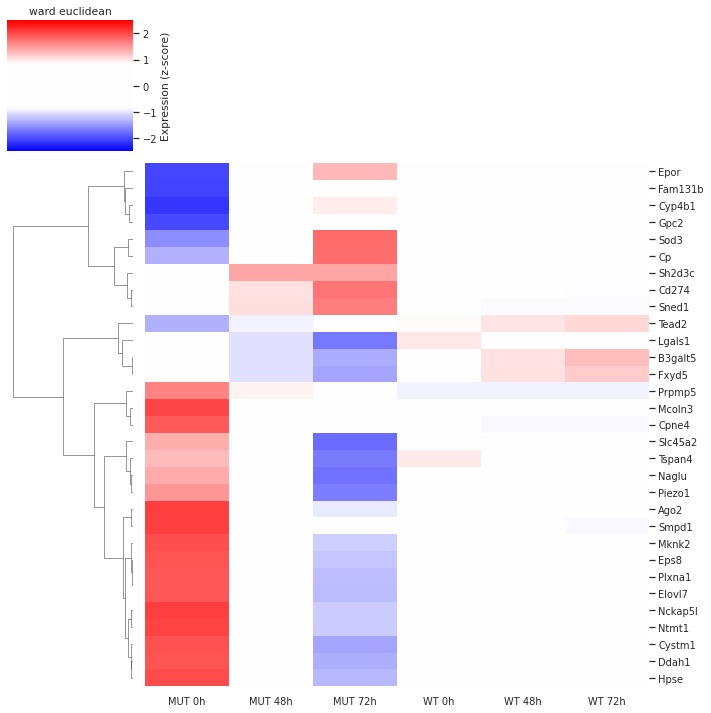

In [27]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

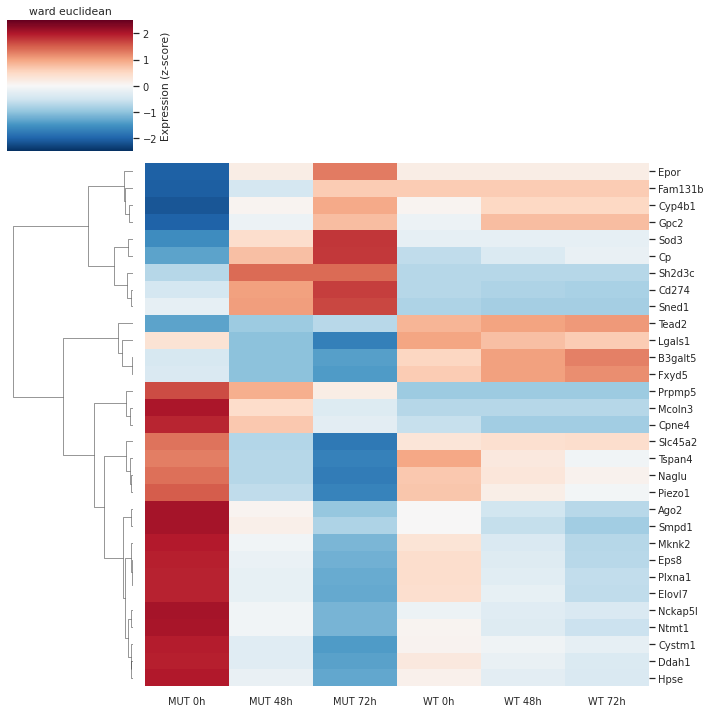

In [28]:
# just a different visualization of the same data
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap='RdBu_r', col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [29]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

## 4.4. pseudo volcano plot

Naglu	-1.218	1.869	tab:blue
Cd274	2.286	1.464	tab:red
Nckap5l	-2.821	2.207	tab:blue
Fam131b	1.170	0.877	tab:red
Cystm1	-1.143	1.985	tab:blue
Slc45a2	-1.252	2.604	tab:blue
Tspan4	-0.840	2.361	gray
Ntmt1	-1.130	1.938	tab:blue
Lgals1	-1.273	3.120	tab:blue
Ddah1	-1.210	1.686	tab:blue
Prpmp5	-1.000	0.381	gray
Sod3	1.415	0.709	tab:red
Ago2	-0.989	1.692	gray
Cyp4b1	2.778	0.692	tab:red
B3galt5	-1.570	1.181	tab:blue
Smpd1	-0.784	1.711	gray
Plxna1	-0.810	2.143	gray
Eps8	-0.936	2.568	gray
Tead2	0.978	1.346	gray
Piezo1	-1.091	1.897	tab:blue
Mknk2	-0.806	2.007	gray
Cp	4.626	1.348	tab:red
Sh2d3c	1.000	0.401	gray
Epor	1.000	0.675	gray
Hpse	-2.435	1.379	tab:blue
Mcoln3	-2.737	0.691	tab:blue
Fxyd5	-1.463	1.172	tab:blue
Gpc2	1.000	0.600	gray
Sned1	2.322	0.812	tab:red
Cpne4	-0.737	0.426	gray
Elovl7	-0.800	1.215	gray


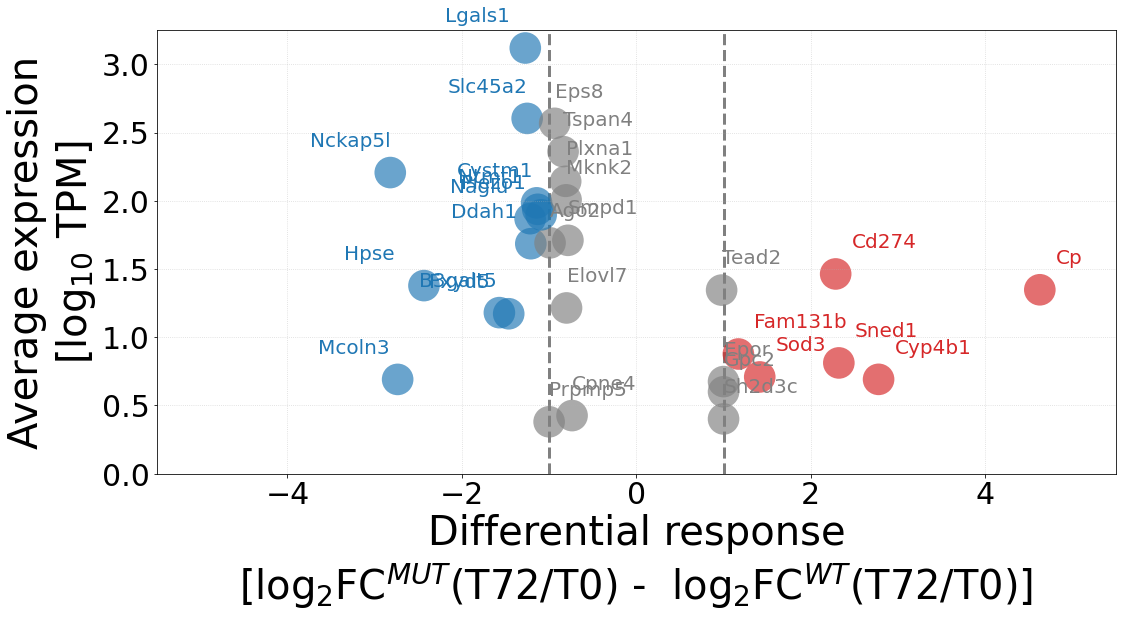

In [30]:
gene_names = rounded_df.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(11/60), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(11/12), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-5.5, 5.5])
matplotlib.pyplot.ylim([0, 3.25])
matplotlib.pyplot.tight_layout()

# 5. Mitf direct targets analysis

## 5.1. read Dorothea database

In [31]:
dorothea = pandas.read_csv(dorothea_file, sep='\t', index_col=0)
print(dorothea.shape)
dorothea.head()

(386758, 4)


tf confidence         target  mor
1  4932411N23Rik          E          Smad4    1
2  4932411N23Rik          E  0610030E20Rik    1
3  4932411N23Rik          E  1700017N19Rik    1
4  4932411N23Rik          E  4931428F04Rik    1
5  4932411N23Rik          E  4932438A13Rik    1

In [32]:
# define gene names for annotation
annotation_gene_names = set(annotation['ext_gene'].to_list())
print('annotation genes: {}'.format(len(annotation_gene_names)))

a = set(dorothea['tf'].to_list())
b = set(dorothea['target'].to_list())
dorothea_genes = a.union(b)
print('dorothea genes: {}'.format(len(dorothea_genes)))


universe = list(annotation_gene_names & dorothea_genes)
print('common universe genes: {}'.format(len(universe)))

annotation genes: 53115
dorothea genes: 17830
common universe genes: 17698


## 5.2. define the set of Mitf direct targets

In [33]:
confidences = ['A', 'B', 'C', 'D', 'E']
direct_targets = dorothea[dorothea['tf'] == 'Mitf']
print(direct_targets.shape)
direct_targets.head()

(37, 4)


tf confidence   target  mor
134897  Mitf          A     Acp5    1
134898  Mitf          A    Apex1    1
134899  Mitf          A     Bcl2    1
134900  Mitf          A  Bcl2a1a   -1
134901  Mitf          A  Bcl2a1b   -1

In [34]:
direct_targets_names = direct_targets['target'].to_list()
print(len(direct_targets_names))

37


## 5.3. define the number of responding genes among Mitf direct target genes

In [35]:
print(direct_targets_names, len(direct_targets_names))
response_genes = gene_names.to_list()
print(response_genes, len(response_genes))

['Acp5', 'Apex1', 'Bcl2', 'Bcl2a1a', 'Bcl2a1b', 'Bcl2a1c', 'Bcl2a1d', 'Best1', 'Birc7', 'Cdk2', 'Clcn7', 'Ctsk', 'Dct', 'Diaph1', 'Fos', 'Gpnmb', 'Gpr143', 'Herc2', 'Hif1a', 'Hoxb4', 'Itpr1', 'Kit', 'Mapre2', 'Met', 'Mlana', 'Oca2', 'Pmel', 'Ppargc1a', 'Prkcb', 'Rab27a', 'Serpinf1', 'Snai2', 'Stard13', 'Tbc1d1', 'Trpm1', 'Tyr', 'Tyrp1'] 37
['Naglu', 'Cd274', 'Nckap5l', 'Fam131b', 'Cystm1', 'Slc45a2', 'Tspan4', 'Ntmt1', 'Lgals1', 'Ddah1', 'Prpmp5', 'Sod3', 'Ago2', 'Cyp4b1', 'B3galt5', 'Smpd1', 'Plxna1', 'Eps8', 'Tead2', 'Piezo1', 'Mknk2', 'Cp', 'Sh2d3c', 'Epor', 'Hpse', 'Mcoln3', 'Fxyd5', 'Gpc2', 'Sned1', 'Cpne4', 'Elovl7'] 31


In [36]:
successes = list(set(direct_targets_names) & set(response_genes))
print(successes)

[]


## 5.4. plot the behaviour of the Mitf direct target genes

In [37]:
list_six = []
for gene_name in direct_targets_names:
    ensembl = annotation[annotation['ext_gene'] == gene_name].index.to_list()[0]
    list_six.append(ensembl)
print(len(list_six))

37


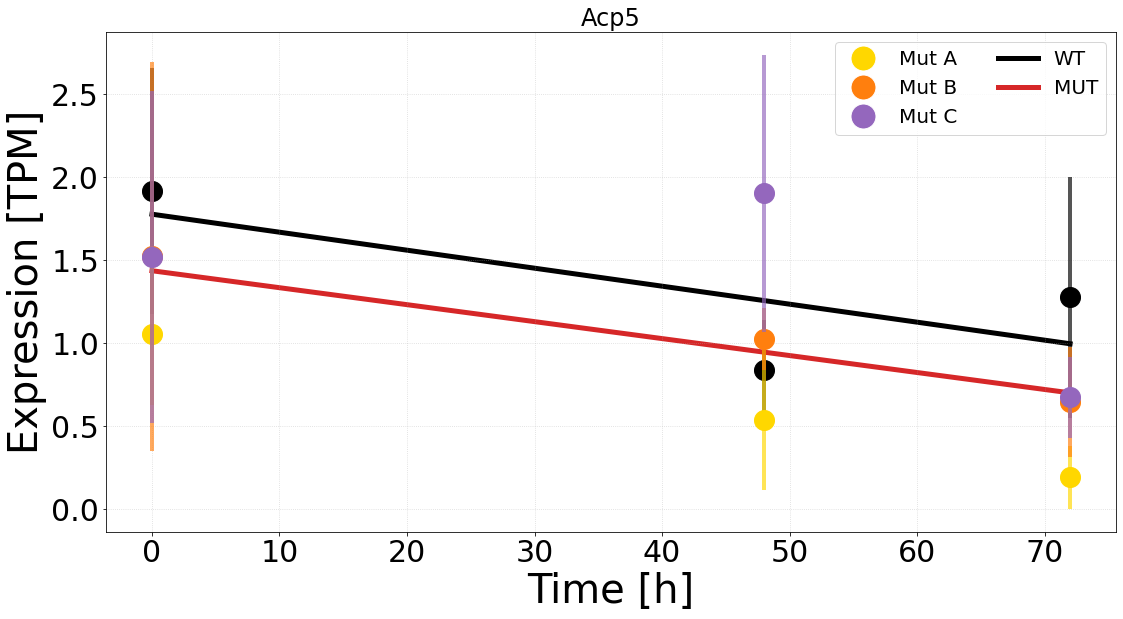

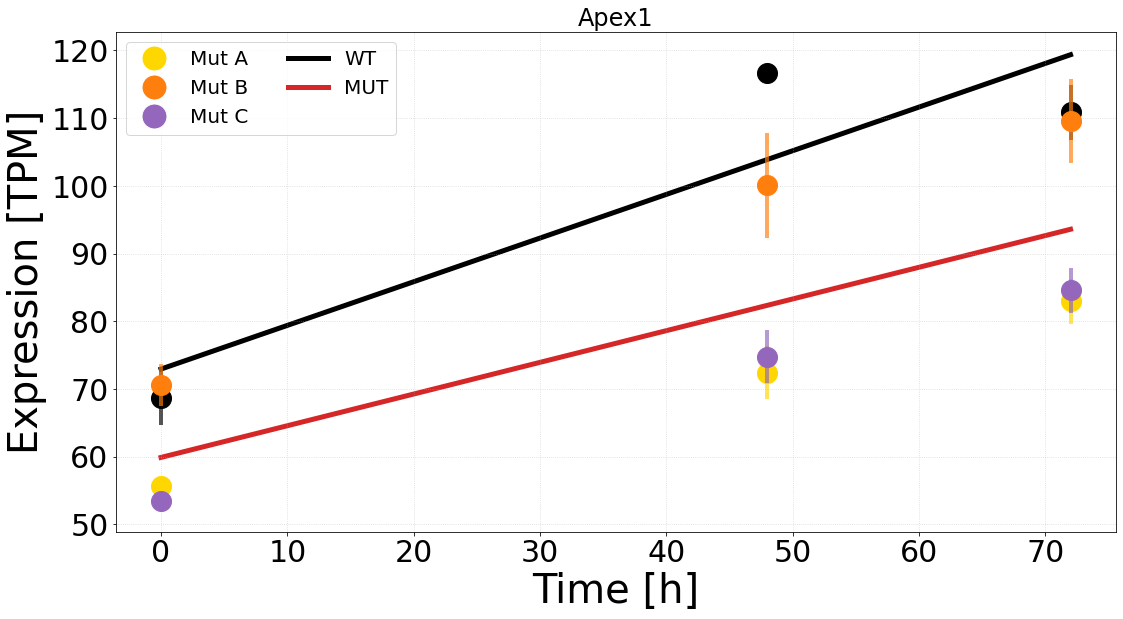

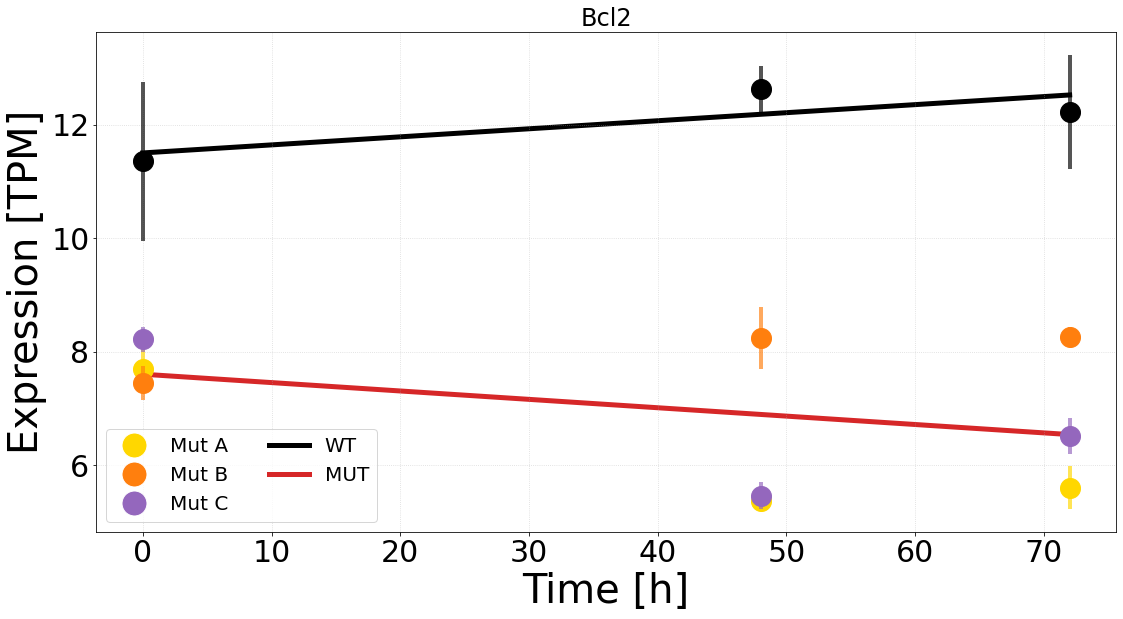

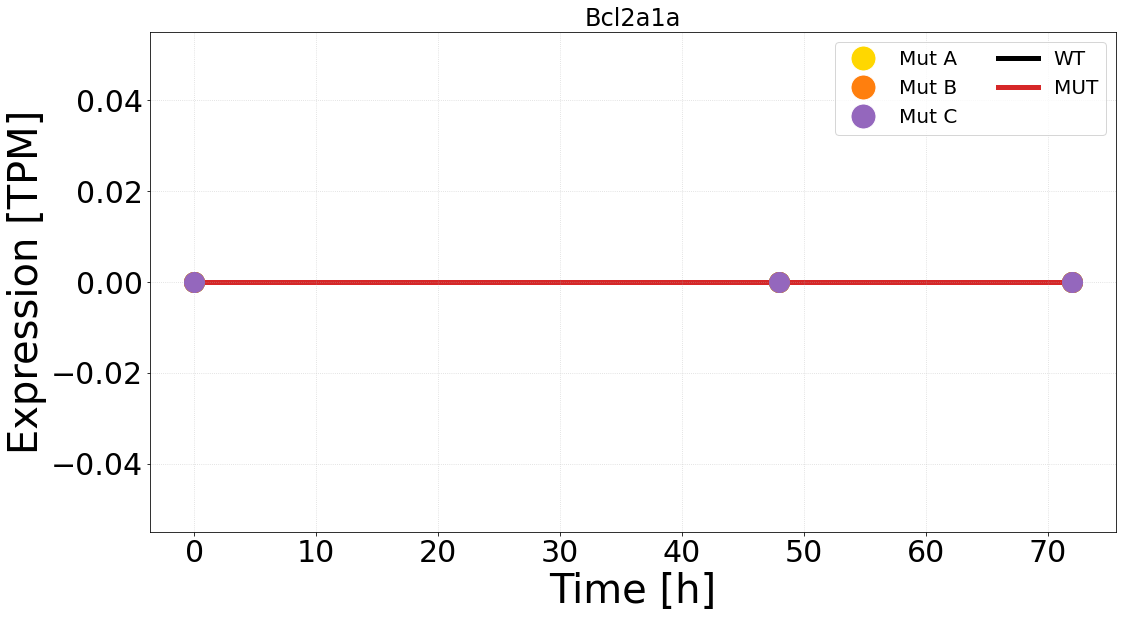

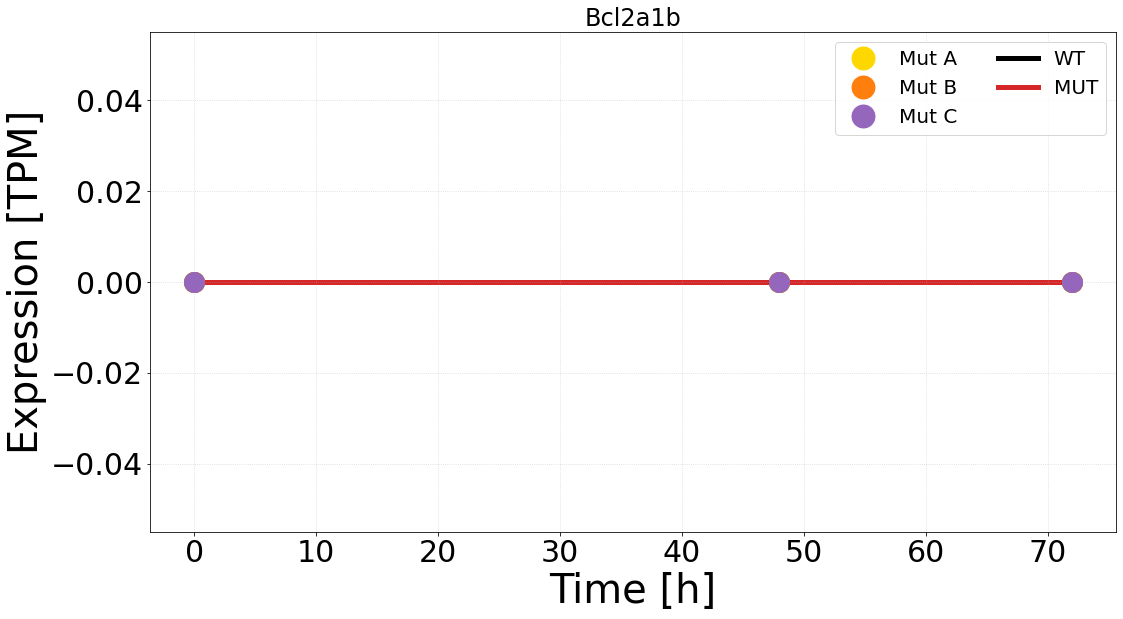

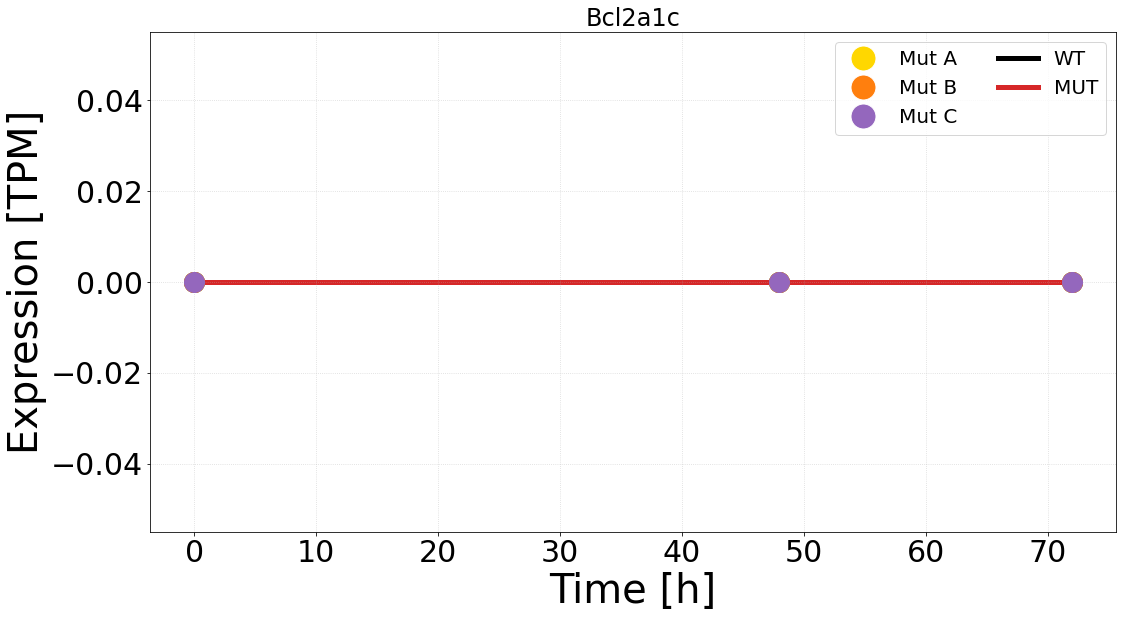

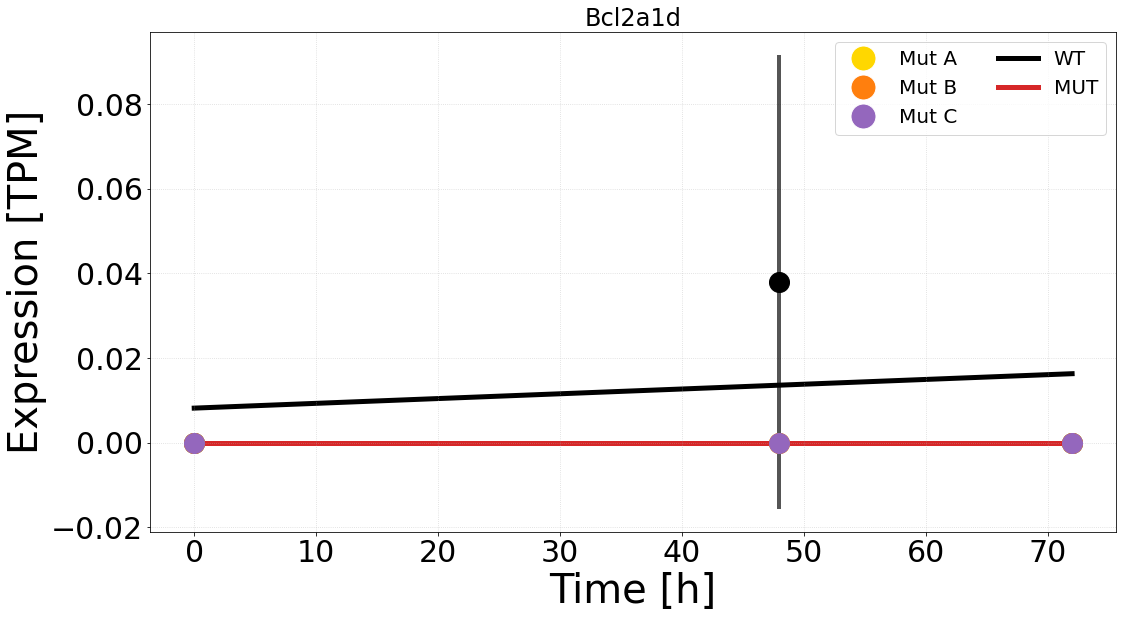

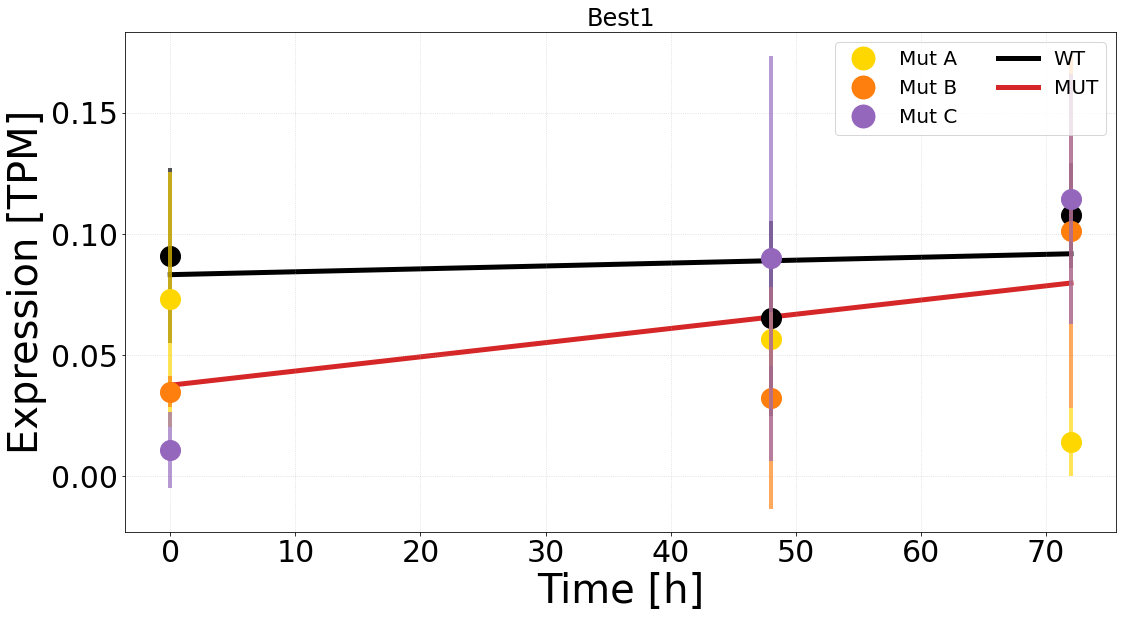

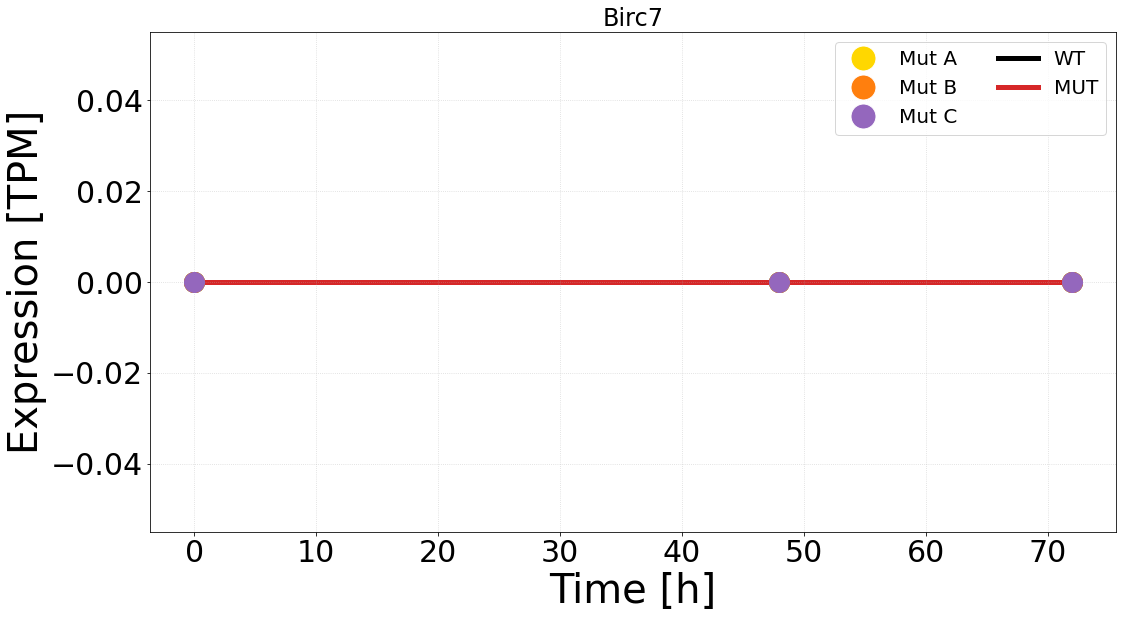

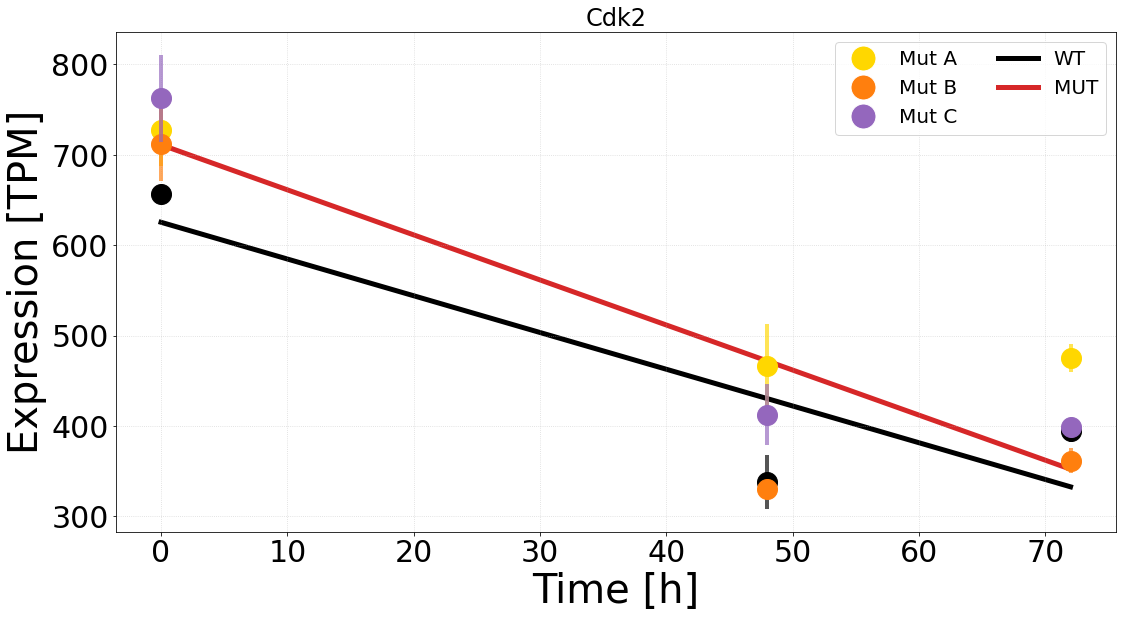

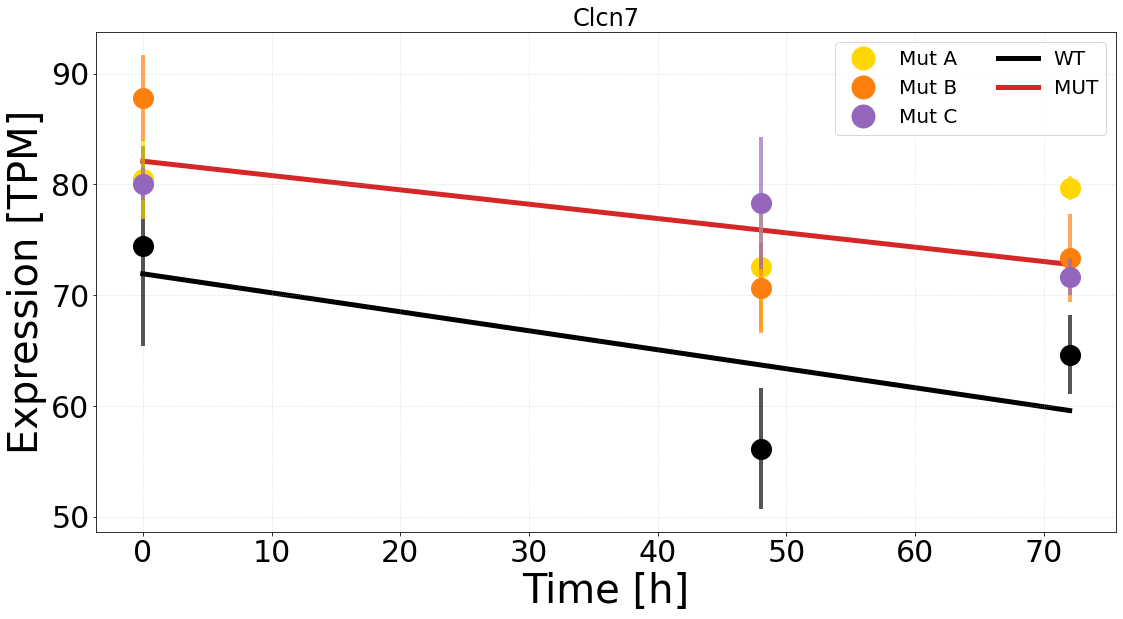

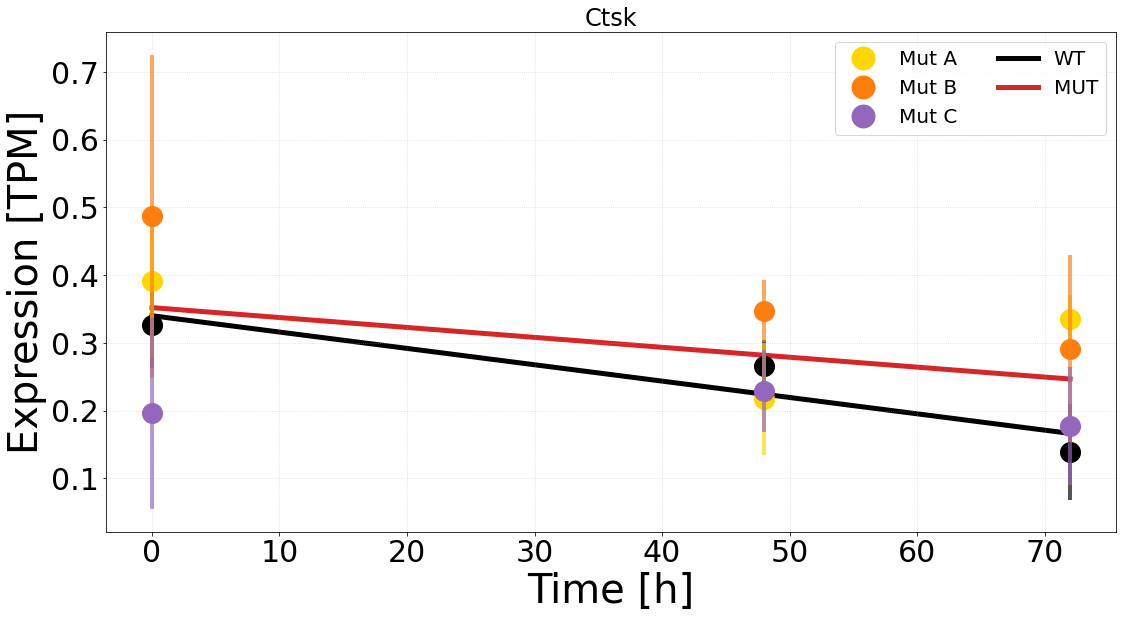

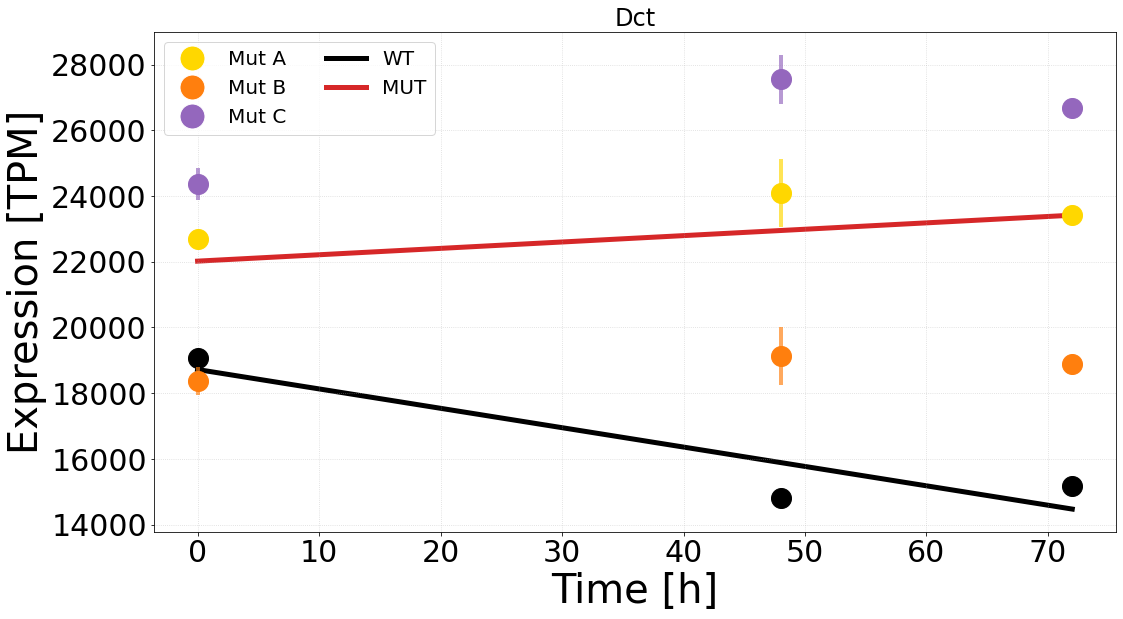

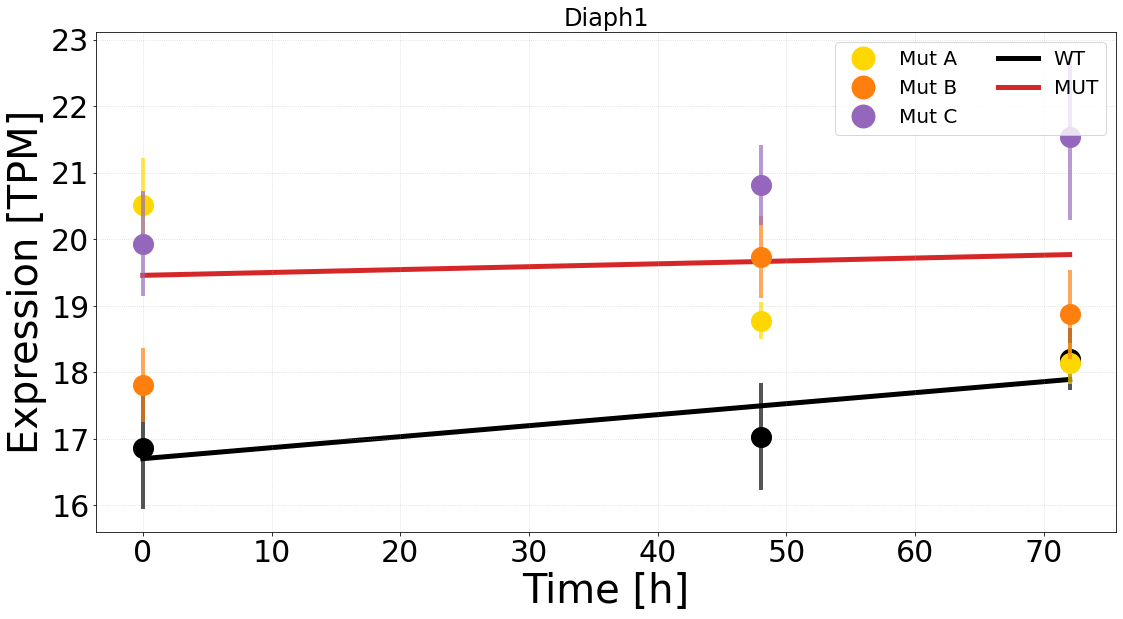

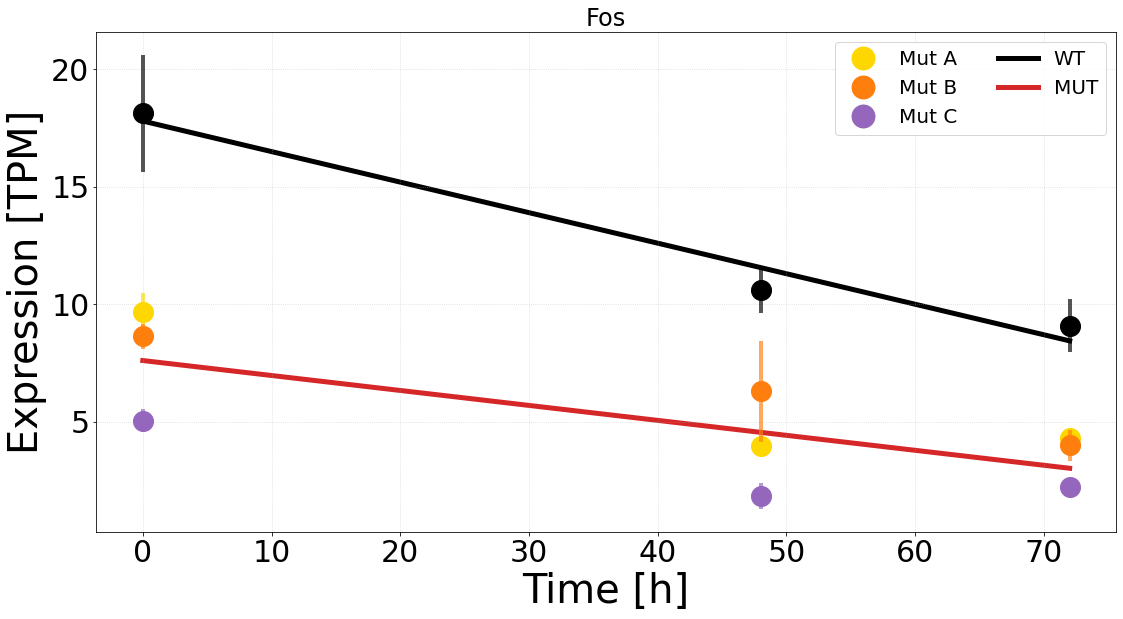

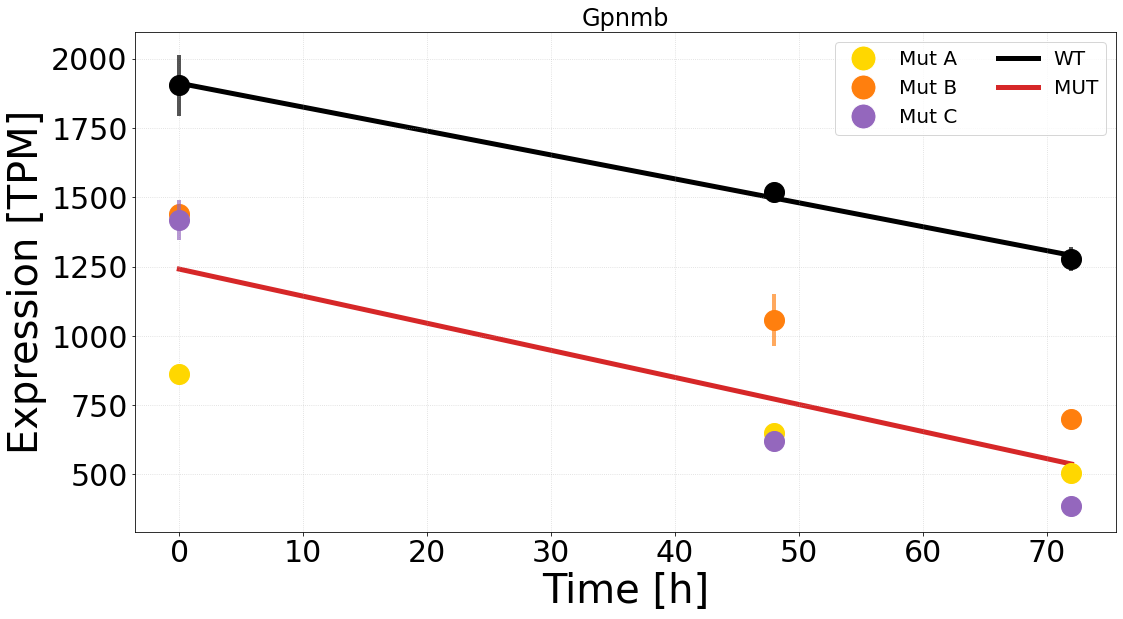

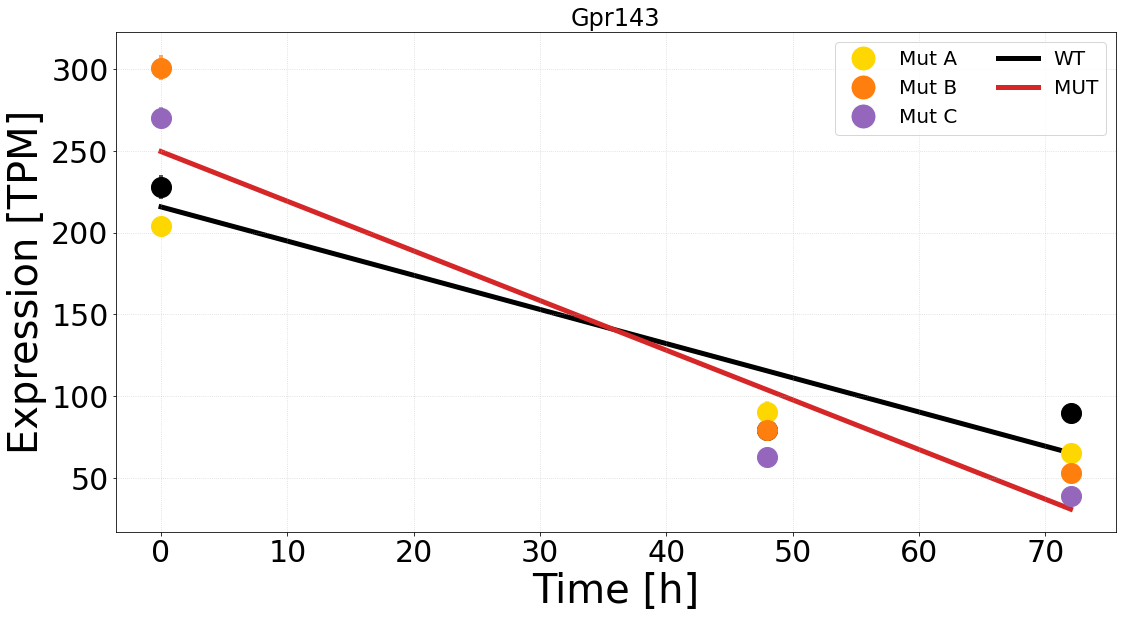

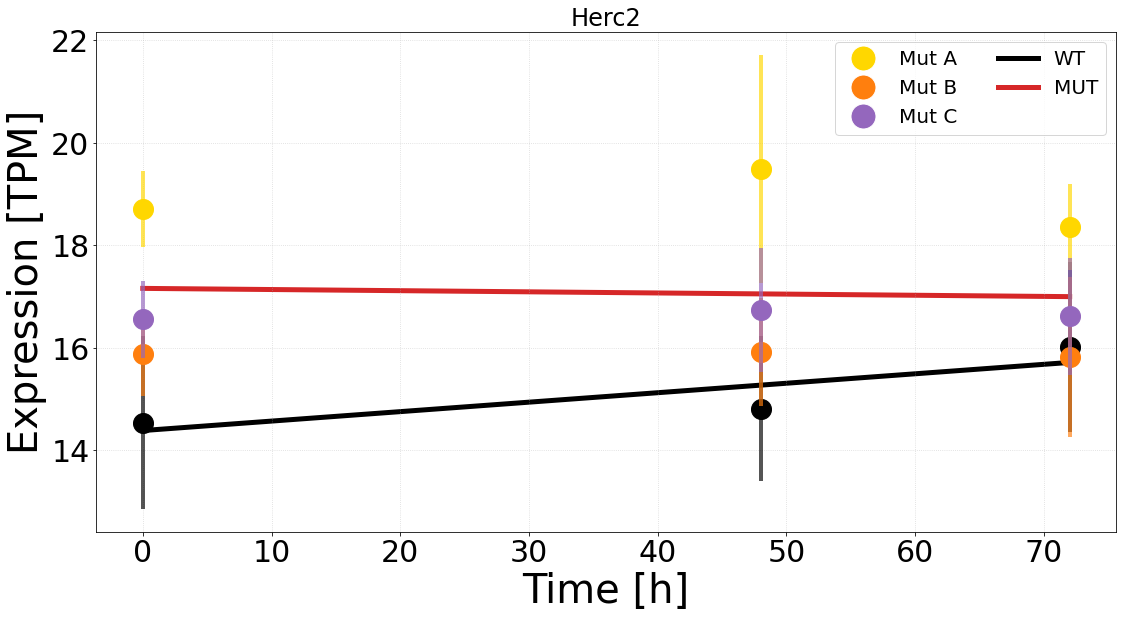

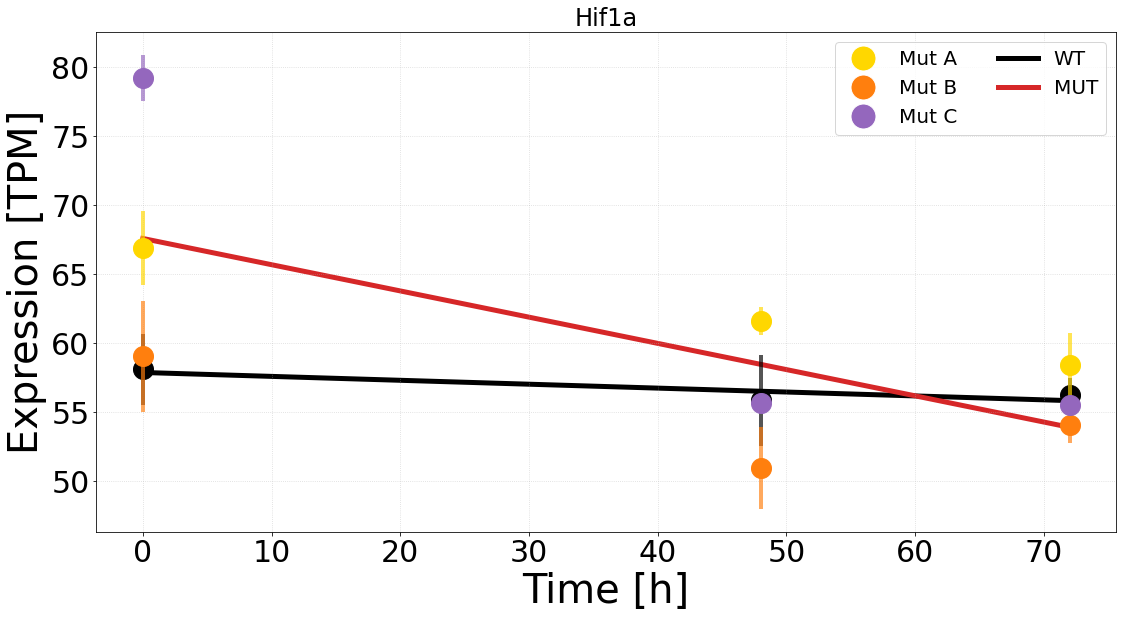

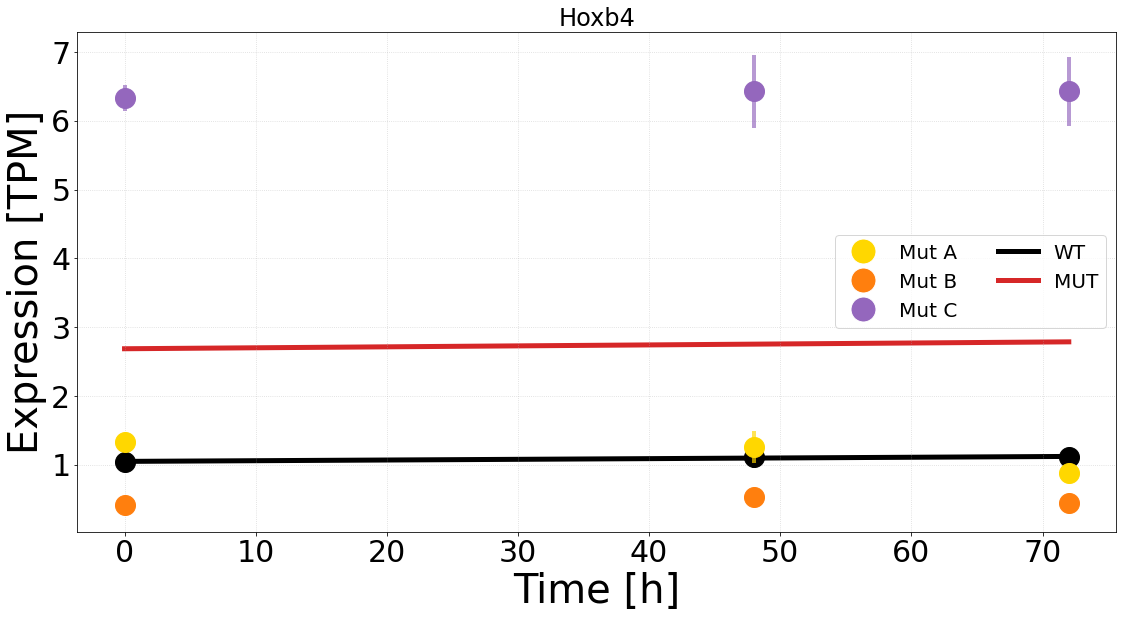

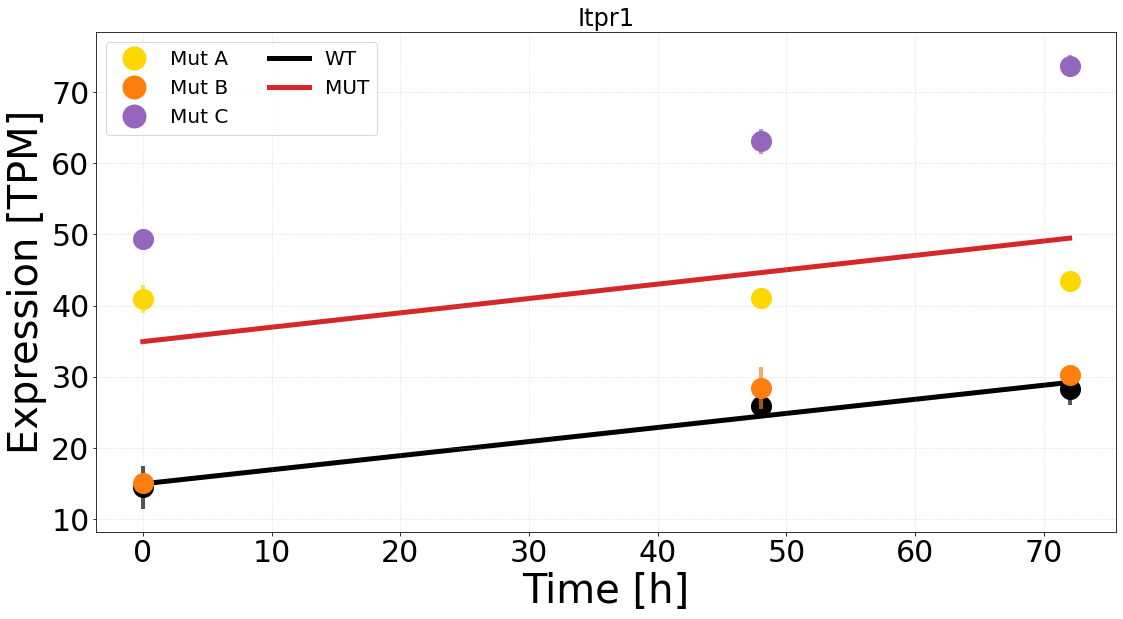

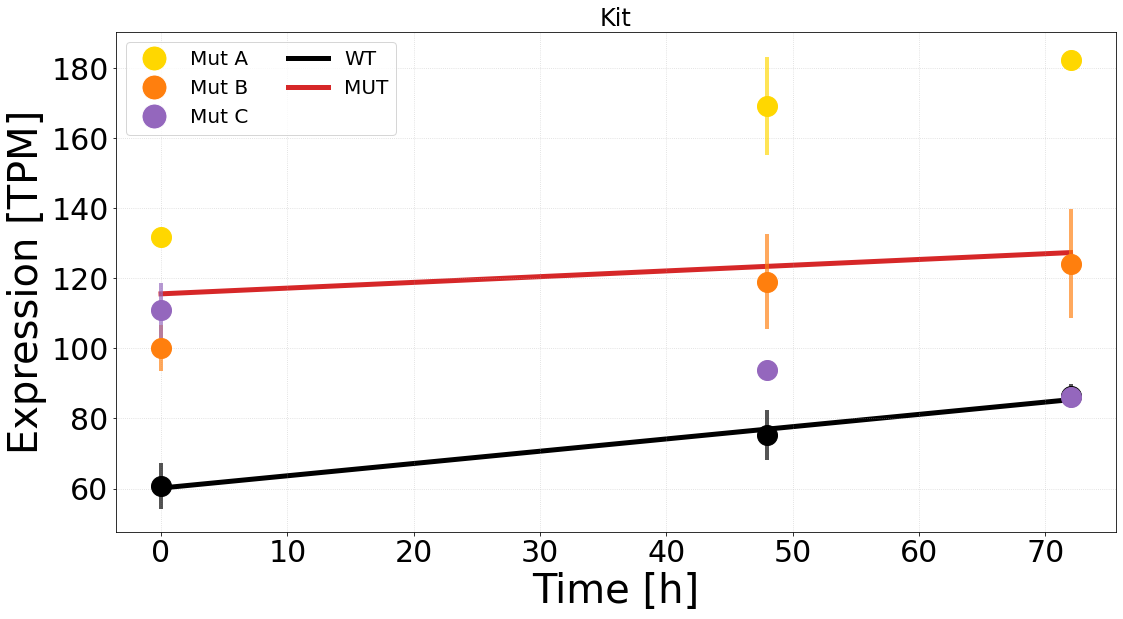

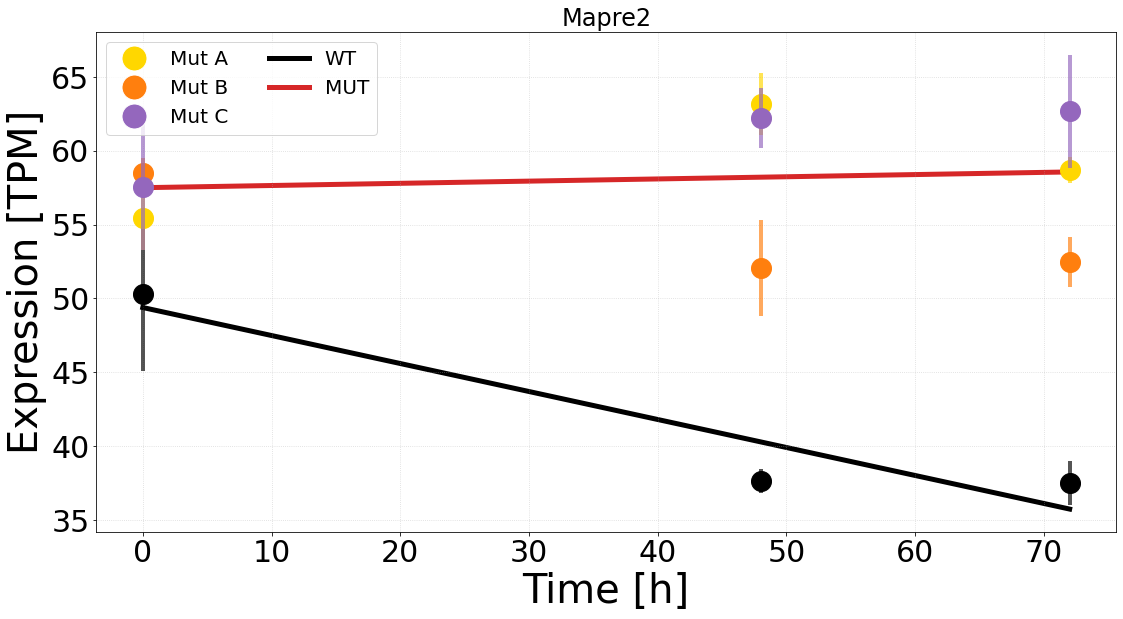

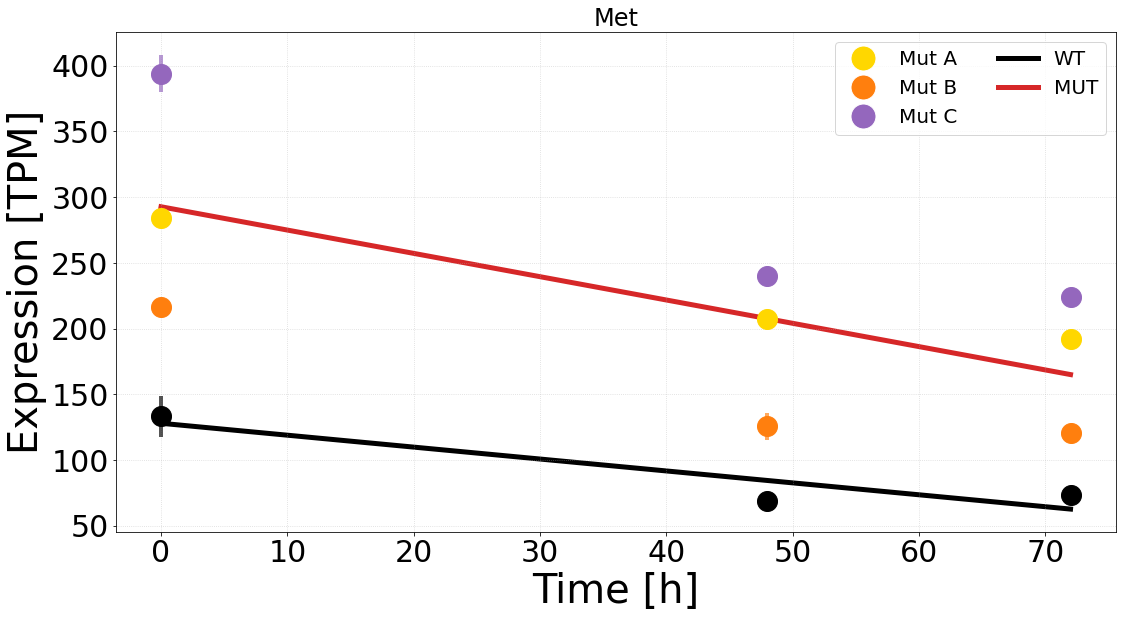

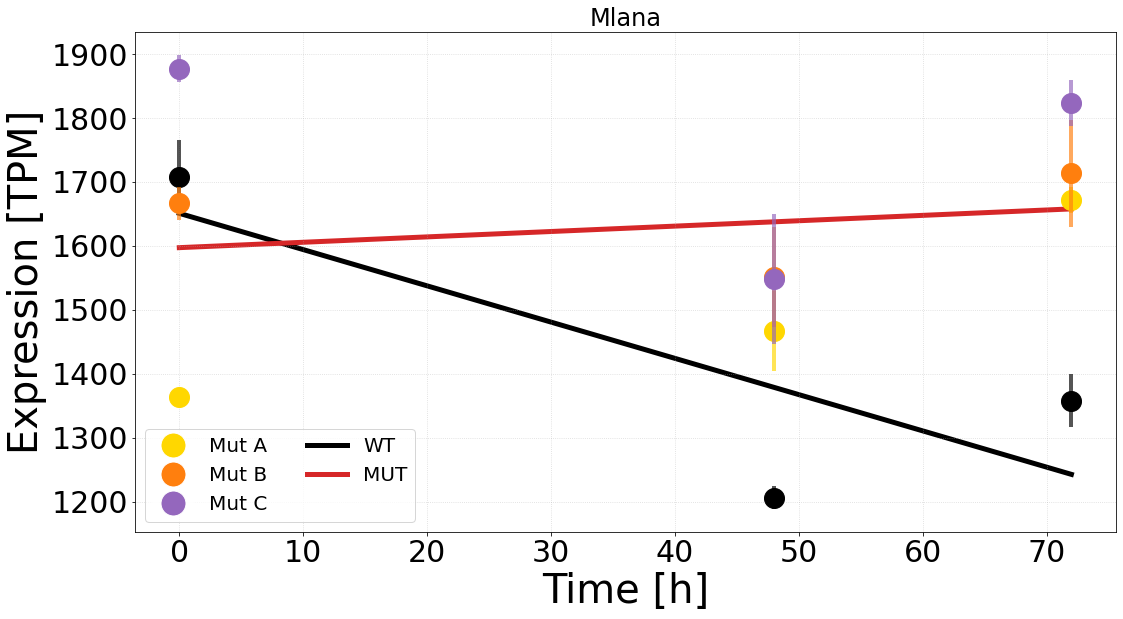

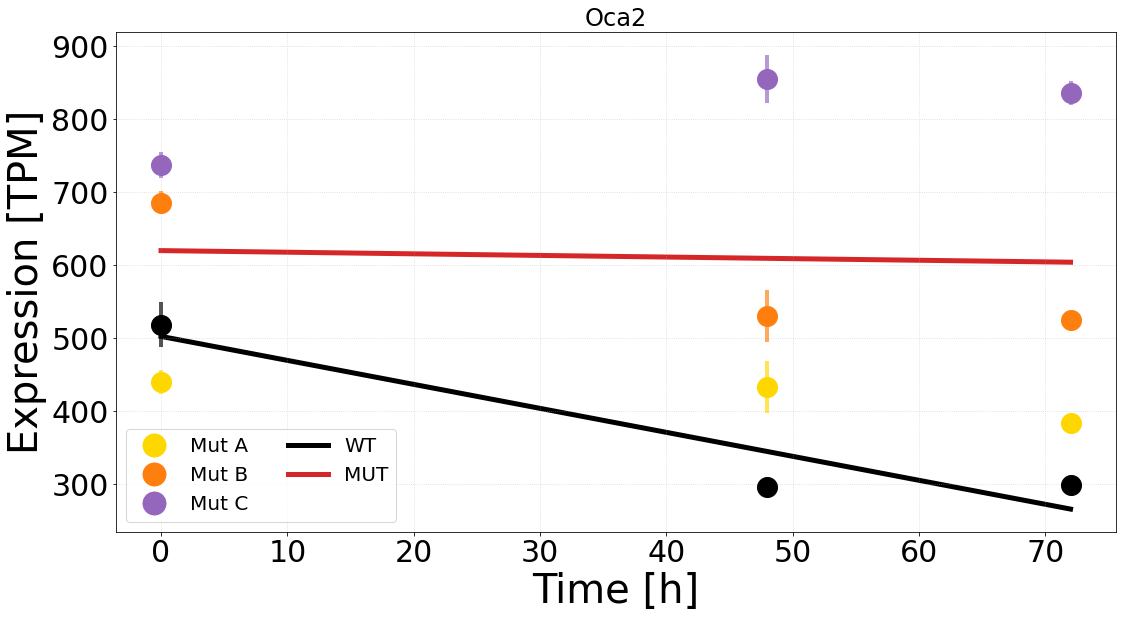

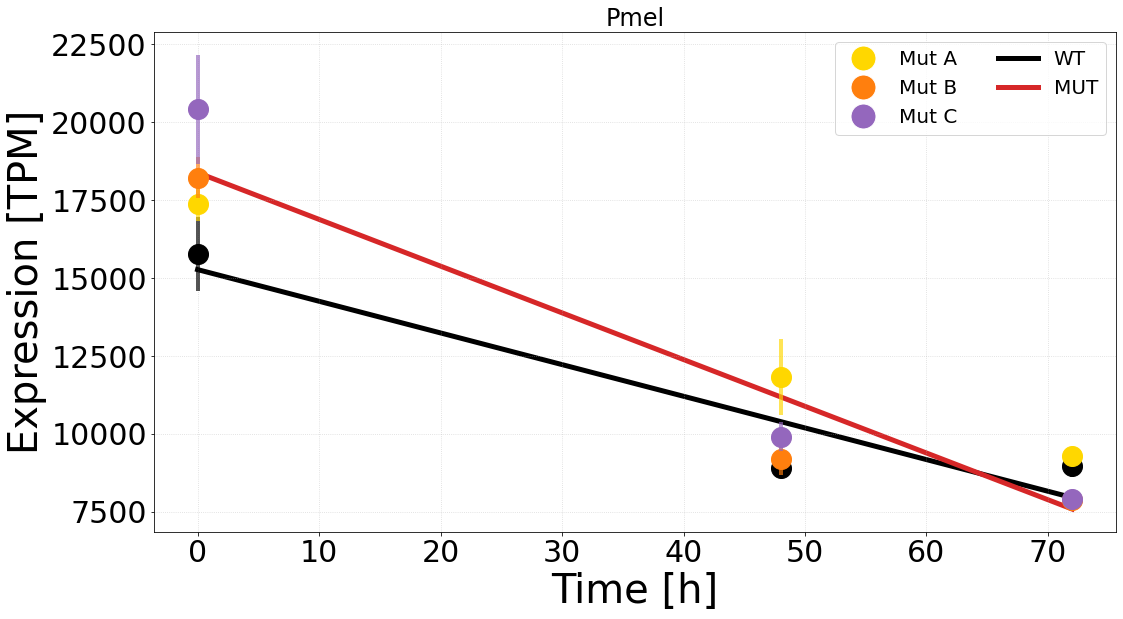

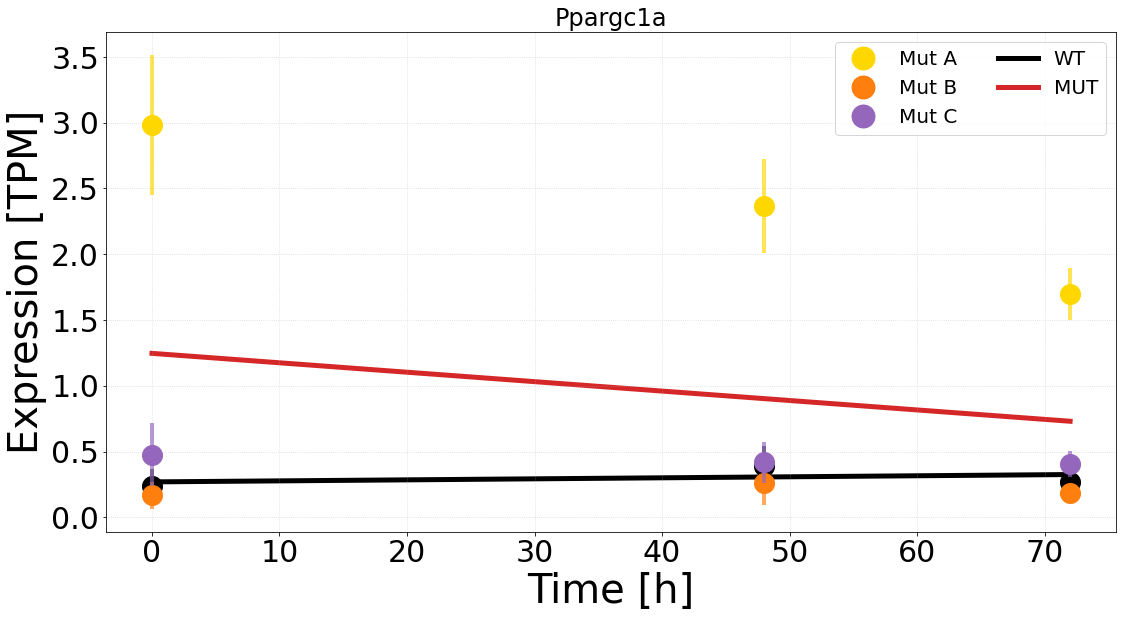

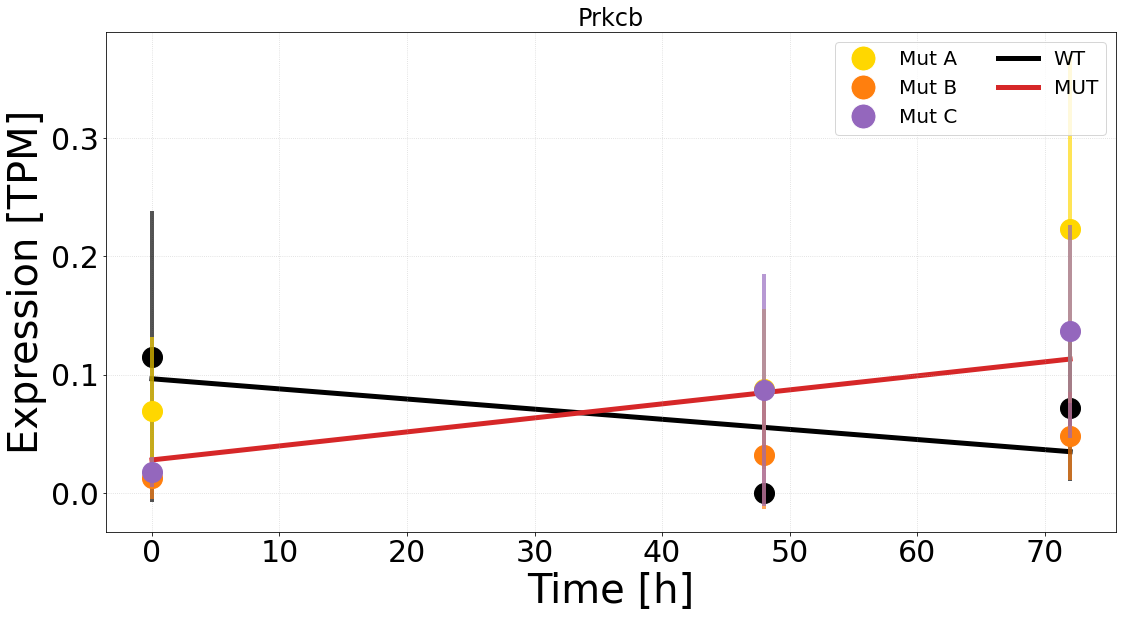

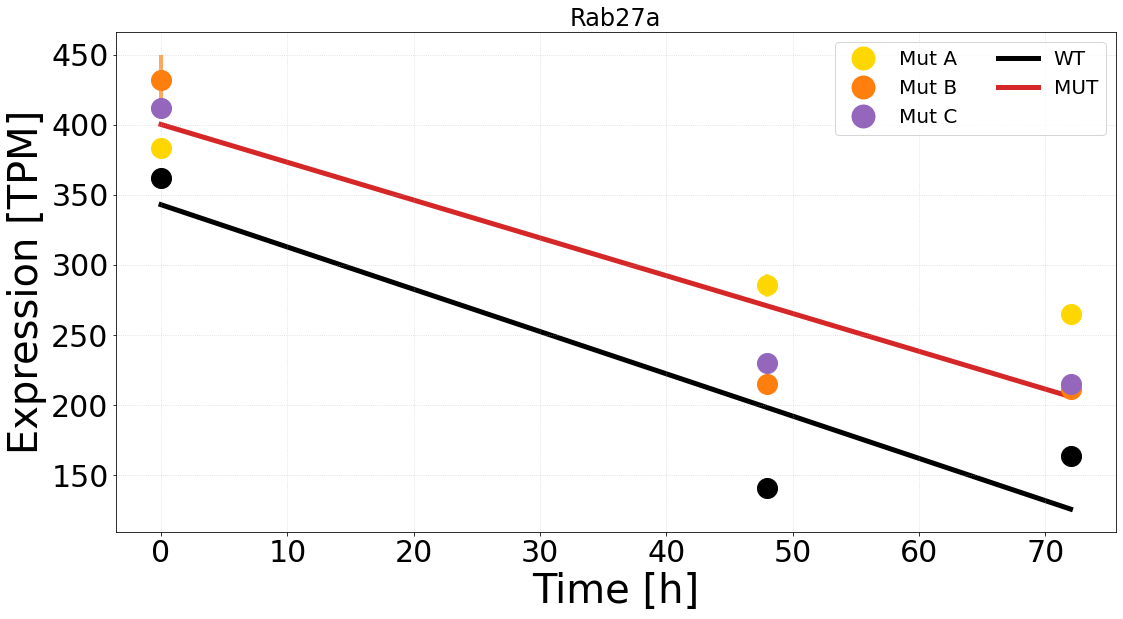

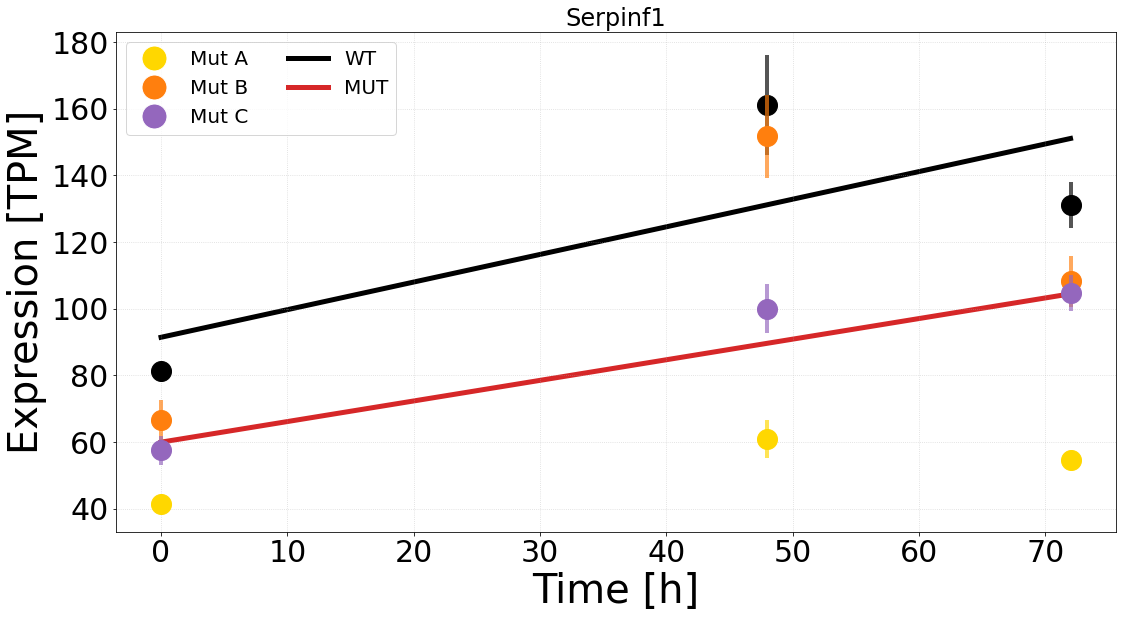

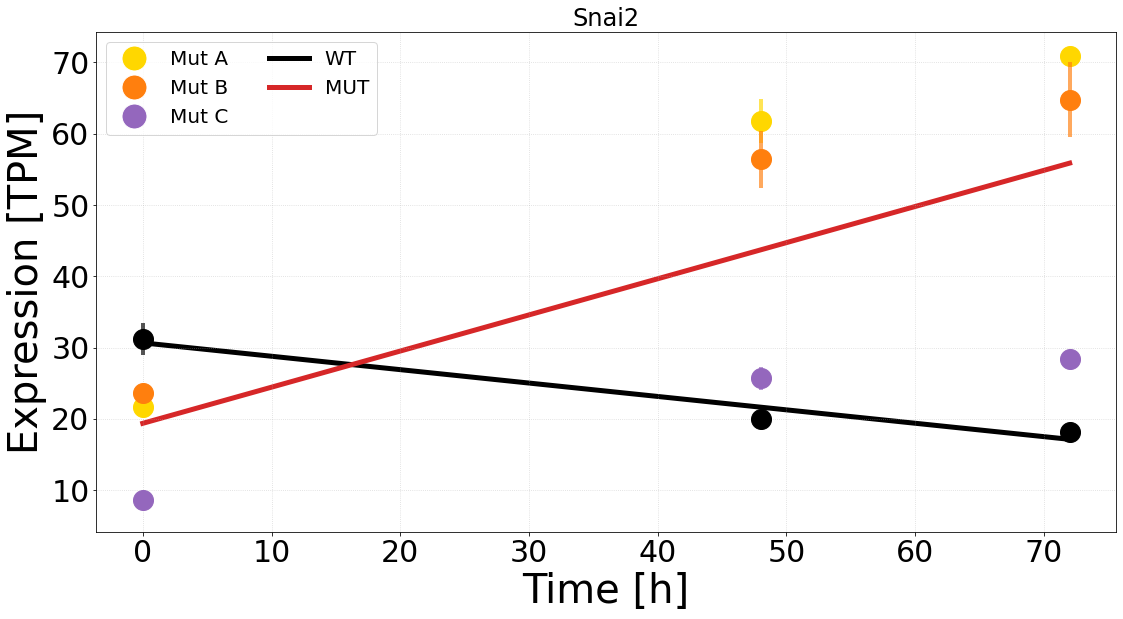

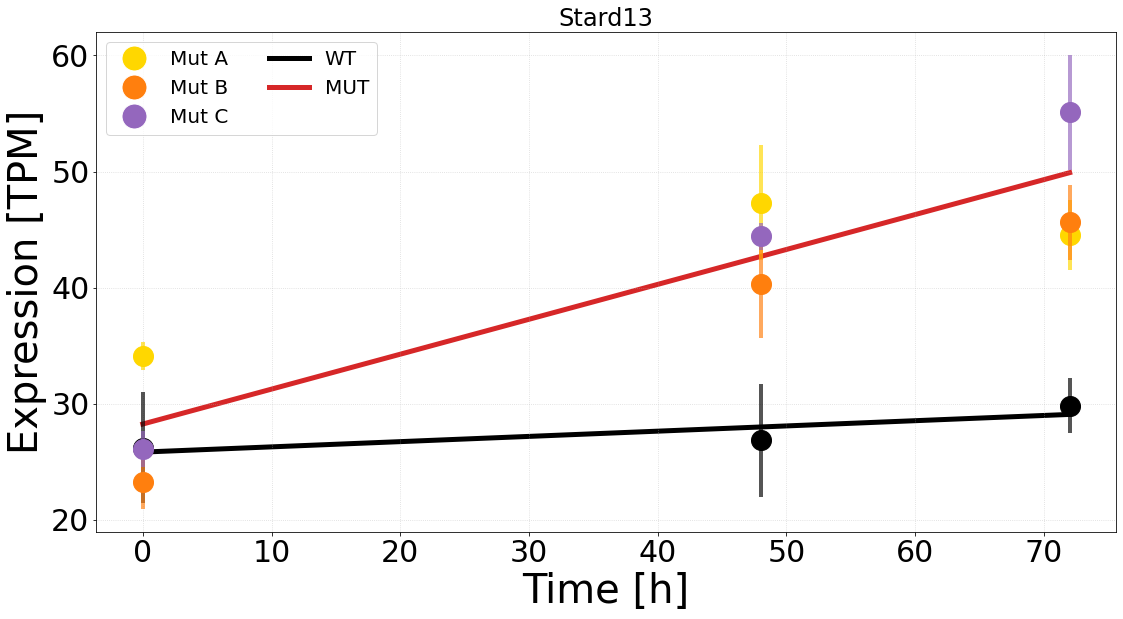

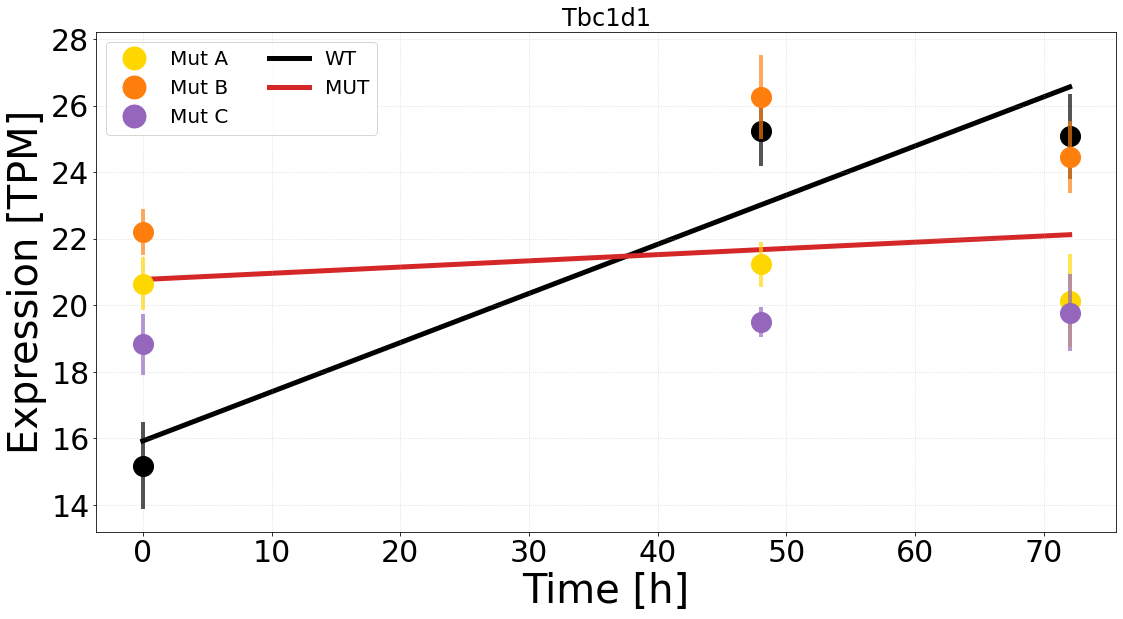

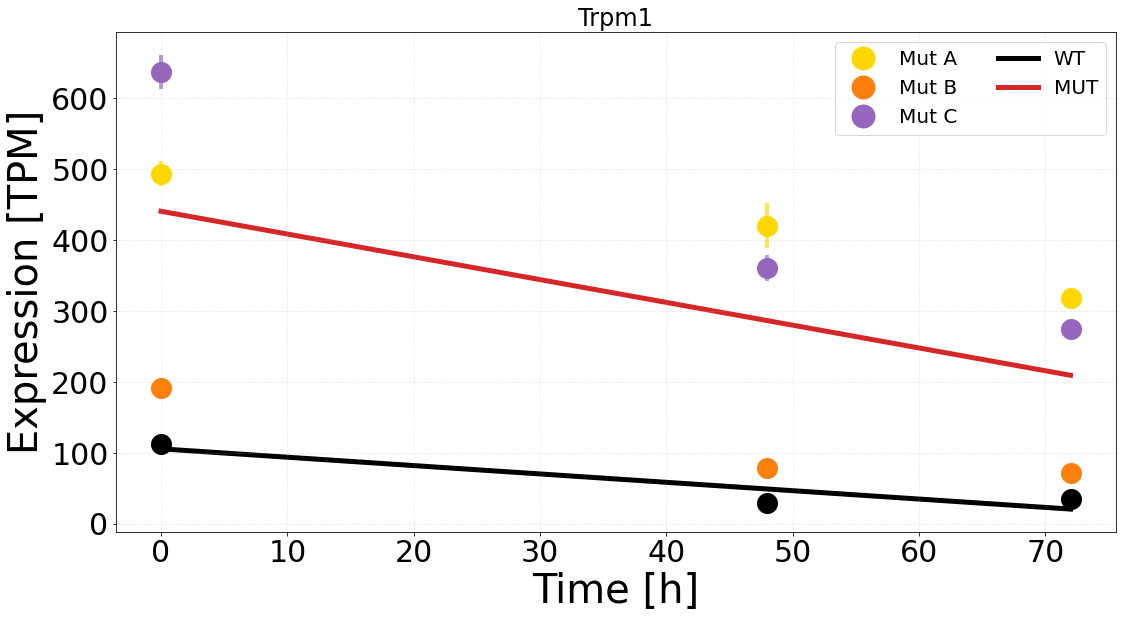

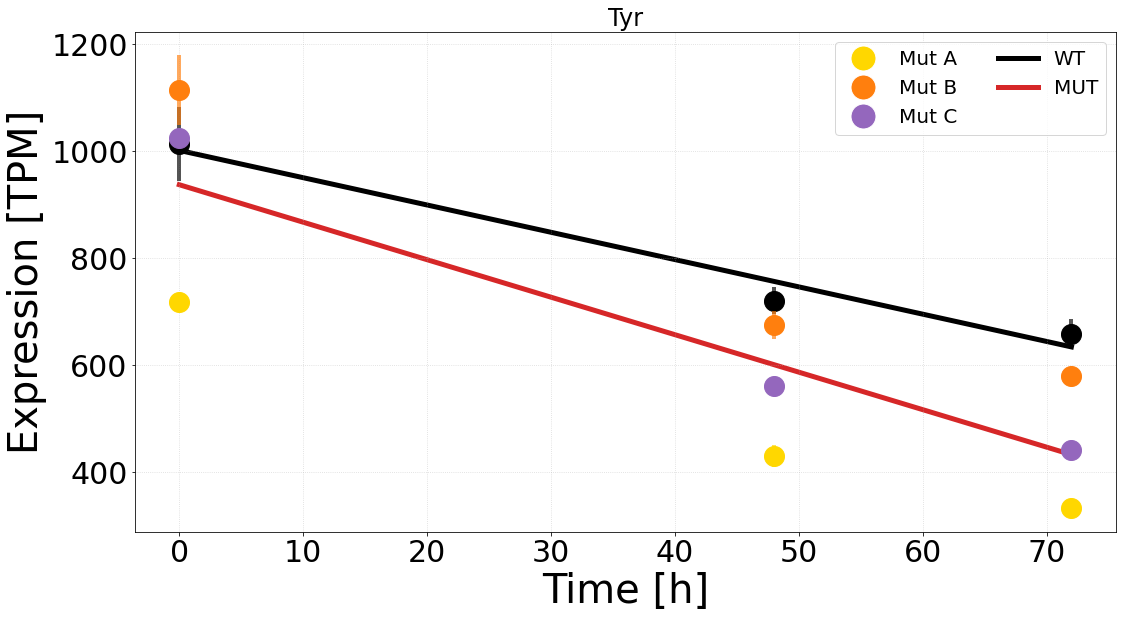

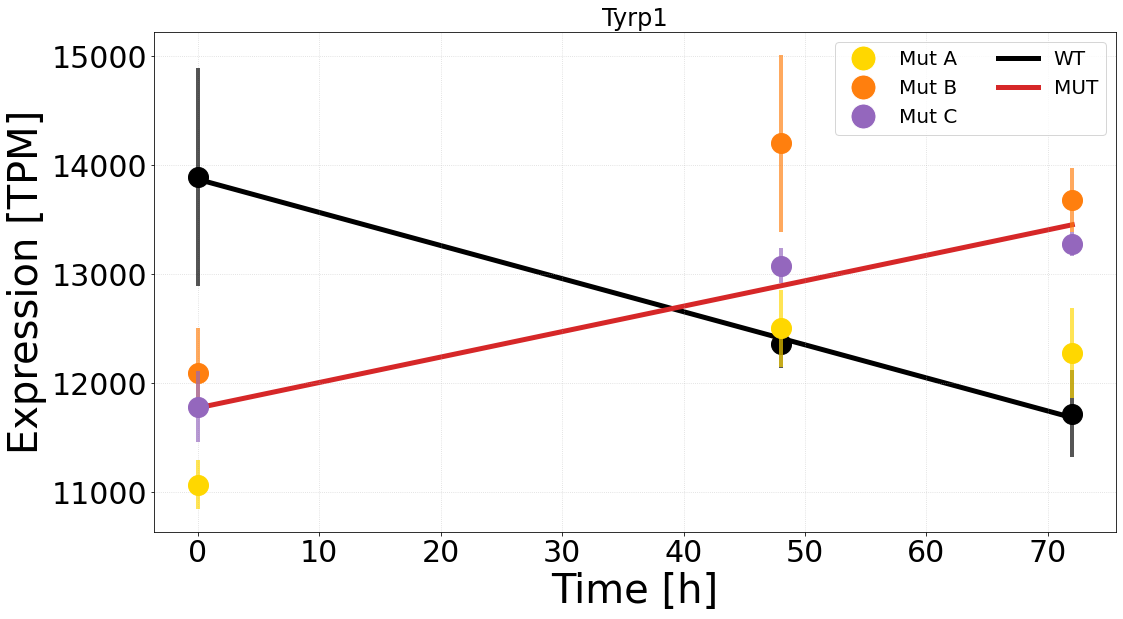

In [38]:
expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

for ensembl in list_six:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name)
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

Except Snai2 (ENSMUSG00000022676), it does not seem that we missed any false negatives.

Snai2 was excluded because in WT there is a -0.75207 log2FC in WT while the threshold for being flat is -0.58496, therefore it was excluded. Yet, Snai2 increases due to Mitf mutation induction, so whether it is a gene responder is up to debate. The main challenge is that is not flat in WT, which is our control conditions.  


Stard13 is not a responding gene because DESEq2 finds that each biological replicate has a log2FC lower than 1, ~ 0.864 maximum. In these plots it seems it passes that threshold, but not within the DESEq2 run.

## 5.5. build a heatmap of direct targets

In [39]:
df = simple_expression.loc[list_six, :]

new_index = {}
for ensembl in list_six:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

print(df.shape)
df.head()

(37, 6)


WT_0h      WT_48h      WT_72h     MUT_0h    MUT_48h    MUT_72h
Acp5      2.406436    0.975128    1.204273   1.720298   1.084472   0.486007
Apex1    66.576630  116.778100  109.005500  56.016420  72.820200  84.336510
Bcl2     12.135310   12.685290   11.630800   7.562797   5.550663   6.292017
Bcl2a1a   0.000000    0.000000    0.000000   0.000000   0.000000   0.000000
Bcl2a1b   0.000000    0.000000    0.000000   0.000000   0.000000   0.000000

In [40]:
rounded_df = numpy.round(df, 0) + 1
rounded_df.head()

WT_0h  WT_48h  WT_72h  MUT_0h  MUT_48h  MUT_72h
Acp5       3.0     2.0     2.0     3.0      2.0      1.0
Apex1     68.0   118.0   110.0    57.0     74.0     85.0
Bcl2      13.0    14.0    13.0     9.0      7.0      7.0
Bcl2a1a    1.0     1.0     1.0     1.0      1.0      1.0
Bcl2a1b    1.0     1.0     1.0     1.0      1.0      1.0

In [41]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in rounded_df.index:
    average_expression = numpy.mean(numpy.log10(rounded_df.loc[gene_name, :]))
    fc_wt = (rounded_df.loc[gene_name, 'WT_72h']) / (rounded_df.loc[gene_name, 'WT_0h'])
    fc_mut = (rounded_df.loc[gene_name, 'MUT_72h']) / (rounded_df.loc[gene_name, 'MUT_0h'])
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    
    volcanox.append(delta); volcanoy.append(average_expression)

In [42]:
zscore_df = scipy.stats.zscore(rounded_df, axis=1)
zscore_df.head()

WT_0h    WT_48h    WT_72h    MUT_0h   MUT_48h   MUT_72h
Acp5     1.212678 -0.242536 -0.242536  1.212678 -0.242536 -1.697749
Apex1   -0.787427  1.483997  1.120569 -1.287140 -0.514856 -0.015143
Bcl2     0.853320  1.194648  0.853320 -0.511992 -1.194648 -1.194648
Bcl2a1a       NaN       NaN       NaN       NaN       NaN       NaN
Bcl2a1b       NaN       NaN       NaN       NaN       NaN       NaN

In [43]:
zscore_df.fillna(0, inplace=True)
zscore_df.head()

WT_0h    WT_48h    WT_72h    MUT_0h   MUT_48h   MUT_72h
Acp5     1.212678 -0.242536 -0.242536  1.212678 -0.242536 -1.697749
Apex1   -0.787427  1.483997  1.120569 -1.287140 -0.514856 -0.015143
Bcl2     0.853320  1.194648  0.853320 -0.511992 -1.194648 -1.194648
Bcl2a1a  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Bcl2a1b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [44]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

MUT_0h   MUT_48h   MUT_72h     WT_0h    WT_48h    WT_72h
Acp5     1.212678 -0.242536 -1.697749  1.212678 -0.242536 -0.242536
Apex1   -1.287140 -0.514856 -0.015143 -0.787427  1.483997  1.120569
Bcl2    -0.511992 -1.194648 -1.194648  0.853320  1.194648  0.853320
Bcl2a1a  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Bcl2a1b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [45]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

2.160673109772235
-1.9789385560713988


In [46]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

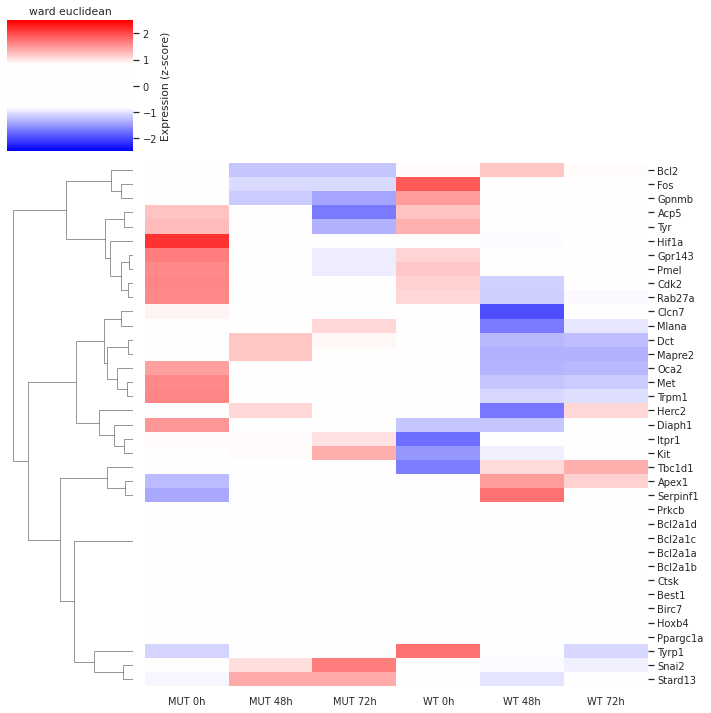

In [47]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [48]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 5.6. pseudo volcano plot

Acp5	-1.000	0.310	gray
Apex1	-0.117	1.917	gray
Bcl2	-0.363	1.003	gray
Bcl2a1a	0.000	0.000	gray
Bcl2a1b	0.000	0.000	gray
Bcl2a1c	0.000	0.000	gray
Bcl2a1d	0.000	0.000	gray
Best1	0.000	0.000	gray
Birc7	0.000	0.000	gray
Cdk2	-0.145	2.673	gray
Clcn7	0.162	1.860	gray
Ctsk	0.000	0.000	gray
Dct	0.391	4.291	gray
Diaph1	-0.148	1.286	gray
Fos	-0.060	0.952	gray
Gpnmb	-0.878	3.043	gray
Gpr143	-0.950	2.052	gray
Herc2	-0.170	1.225	gray
Hif1a	-0.297	1.771	gray
Hoxb4	0.000	0.301	gray
Itpr1	-0.840	1.503	gray
Kit	-0.369	1.968	gray
Mapre2	0.554	1.704	gray
Met	0.418	2.153	gray
Mlana	0.379	3.183	gray
Oca2	0.527	2.655	gray
Pmel	-0.286	4.043	gray
Ppargc1a	0.000	0.000	gray
Prkcb	0.000	0.000	gray
Rab27a	0.159	2.373	gray
Serpinf1	0.181	2.007	gray
Snai2	2.337	1.510	tab:red
Stard13	0.823	1.515	gray
Tbc1d1	-0.735	1.347	gray
Trpm1	0.779	2.126	gray
Tyr	-0.575	2.850	gray
Tyrp1	0.430	4.107	gray


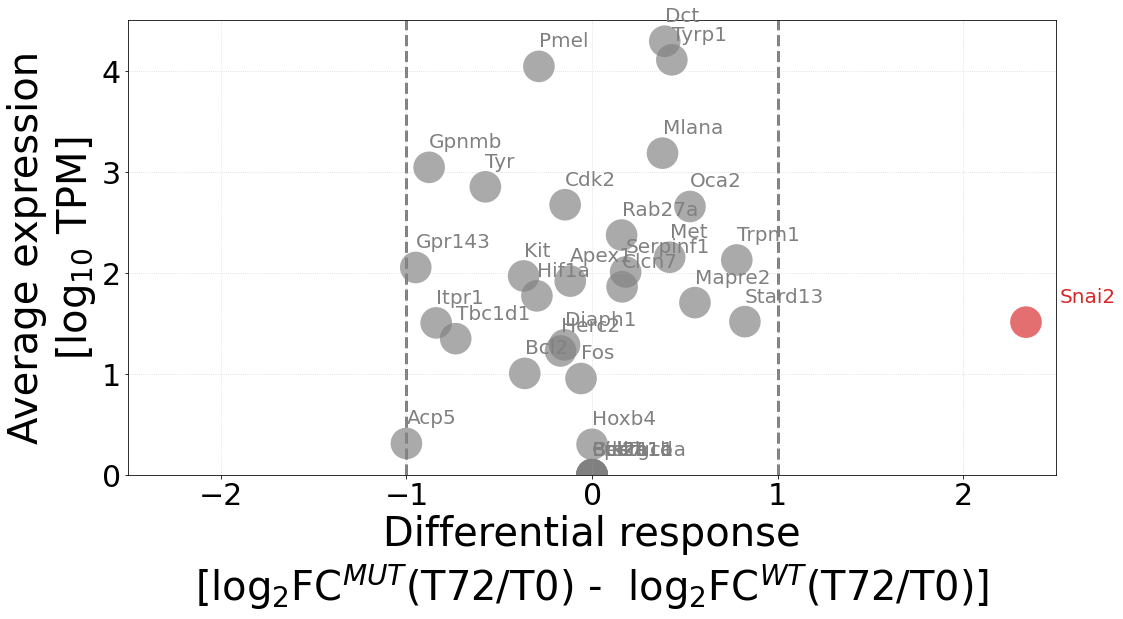

In [49]:
gene_names = rounded_df.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(11/60), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(11/12), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-2.5, 2.5])
matplotlib.pyplot.ylim([0, 4.5])
matplotlib.pyplot.tight_layout()

Snai2 was excluded because in WT there is a -0.75207 log2FC in WT while the threshold for being flat is -0.58496, therefore it was excluded. Yet, Snai2 increases due to Mitf mutation induction, so whether it is a gene responder is up to debate. The main challenge is that is not flat in WT, which is our control conditions.